# Setup & Accessing the License Plate Dataset from Kaggle

Import Necessary Libaries

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import cv2
from google.colab.patches import cv2_imshow
import kagglehub
from tqdm import tqdm
import shutil as sh
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
import tensorflow as tf
import random
import yaml
from tensorflow.keras.models import load_model

Import Dataset

100%|██████████| 203M/203M [00:01<00:00, 168MB/s]

Extracting files...


Image dimensions: (225, 400, 4)


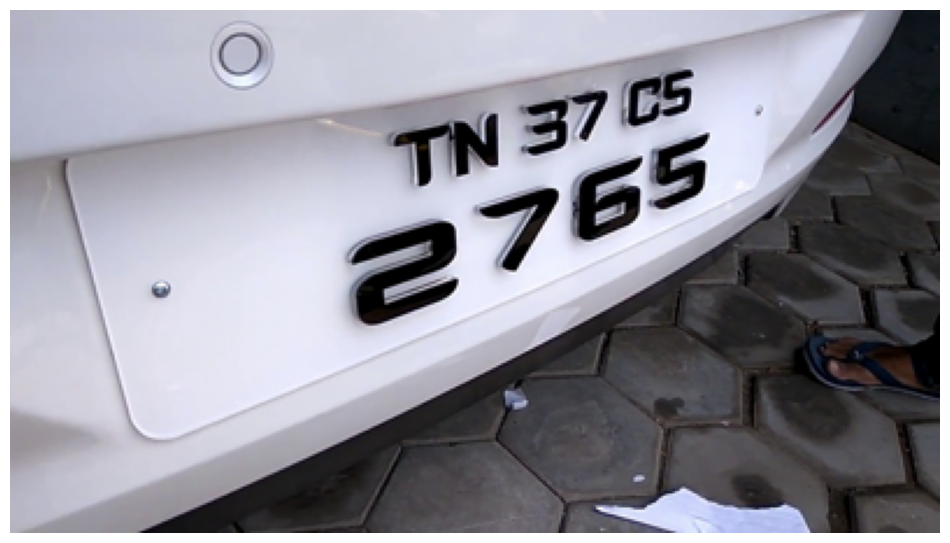

In [2]:
#Download dataset & #store paths to the dataset folders
dataset_path = kagglehub.dataset_download("andrewmvd/car-plate-detection")

annotations_path = f"{dataset_path}/annotations"
images_path = f"{dataset_path}/images"

#Demonstrate loading one of the images
image_filename = 'Cars10.png'
img = plt.imread(f"{images_path}/{image_filename}")
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')
ax.imshow(img)
print('Image dimensions: {}'.format(img.shape))




Open up the sample .xml file to see how the properties are arranged

In [3]:
#We will open Cars10.xml as our sample file
sample_path = f"{annotations_path}/Cars10.xml"
with open(sample_path, 'r') as file:
  data = file.read()

print(data)


<annotation>
    <folder>images</folder>
    <filename>Cars10.png</filename>
    <size>
        <width>400</width>
        <height>225</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>140</xmin>
            <ymin>5</ymin>
            <xmax>303</xmax>
            <ymax>148</ymax>
        </bndbox>
    </object>
</annotation>


Define our Dictionary & store the annotations properties in our dictionary

In [4]:
#The labels from the annotation properties above that we want to store
dataset = dict()
dataset["filename"] = list()
dataset["name"] = list()
dataset["width"] = list()
dataset["height"] = list()
dataset["xmin"] = list()
dataset["ymin"] = list()
dataset["xmax"] = list()
dataset["ymax"] = list()

In [5]:
for curr_annotation in os.listdir(annotations_path):
  if curr_annotation.endswith('.xml'):
    curr_path = f"{annotations_path}/{curr_annotation}"
    properties = ET.parse(curr_path)
    filename = properties.find('filename').text
    for item in properties.iter():
      if 'size' in item.tag:
        for val in list(item):
          if 'width' in val.tag:
            width = int(round(float(val.text)))
          if 'height' in val.tag:
            height = int(round(float(val.text)))
      if 'object' in item.tag:
        for val in list(item):
          if 'name' in val.tag:
            name = val.text
            dataset['name'].append(name)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['filename'].append(filename)
          if 'bndbox' in val.tag:
            for dim in list(val):
              if 'xmin' in dim.tag:
                xmin = int(round(float(dim.text)))
                dataset['xmin'].append(xmin)
              if 'ymin' in dim.tag:
                ymin = int(round(float(dim.text)))
                dataset['ymin'].append(ymin)
              if 'xmax' in dim.tag:
                xmax = int(round(float(dim.text)))
                dataset['xmax'].append(xmax)
              if 'ymax' in dim.tag:
                ymax = int(round(float(dim.text)))
                dataset['ymax'].append(ymax)

In [6]:
#Store data in a dataframe and print first few items
df = pd.DataFrame(dataset)
df.head()

,filename,name,width,height,xmin,ymin,xmax,ymax
0,Cars389.png,licence,600,450,77,305,222,370
1,Cars254.png,licence,400,367,166,175,235,207
2,Cars293.png,licence,400,267,64,160,130,181
3,Cars378.png,licence,400,307,118,92,254,137
4,Cars9.png,licence,442,333,164,224,272,247


Calculate normalized bounding box coordinates and dimensions

In [7]:
df['category'] = df['name'].apply(lambda x: 0 if x == 'licence' else x)
df['center_x'] = df.apply(lambda row: (row['xmin'] + row['xmax']) / (2 * row['width']), axis=1)
df['center_y'] = df.apply(lambda row: (row['ymin'] + row['ymax']) / (2 * row['height']), axis=1)
df['square_w'] = df.apply(lambda row: abs(row['xmax'] - row['xmin']) / row['width'], axis=1)
df['square_h'] = df.apply(lambda row: abs(row['ymax'] - row['ymin']) / row['height'], axis=1)
df[['category', 'center_x', 'center_y', 'square_w', 'square_h']].head()


,category,center_x,center_y,square_w,square_h
0,0,0.249167,0.750000,0.241667,0.144444
1,0,0.501250,0.520436,0.172500,0.087193
2,0,0.242500,0.638577,0.165000,0.078652
3,0,0.465000,0.372964,0.340000,0.146580
4,0,0.493213,0.707207,0.244344,0.069069


Split unique images into training and validation sets

In [8]:
unique_imgs = df['filename'].unique().tolist()
training_imgs, validation_imgs = train_test_split(unique_imgs, test_size=0.1, random_state=123)
print(f'Training set size: {len(training_imgs)}')
print(f'Validation set size: {len(validation_imgs)}')


Training set size: 389
Validation set size: 44


# Preprocessing dataset into black and white

(Demonstration) Transform image by converting to grayscale and applying adaptive thresholding for easier detection of the contours, boxes, and characters

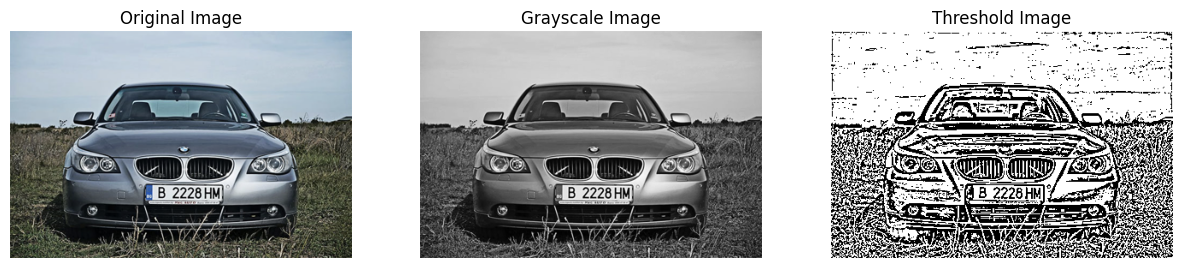

In [7]:
sample_img = cv2.imread(f"{images_path}/Cars120.png")
gray_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
final_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(gray_img, cmap='gray')
axes[1].set_title("Grayscale Image")
axes[1].axis('off')
axes[2].imshow(final_img, cmap='gray')
axes[2].set_title("Threshold Image")
axes[2].axis('off')
plt.show()


Make a new folder to store the processed images

In [ ]:
try:
  os.makedirs("new_images/")
except FileExistsError:
  pass

n_images_path = "new_images/"
#sh.copytree(images_path, n_images_path, dirs_exist_ok=True)

Apply the transformations above to all of the car images and then store them in the new folders

In [ ]:
for image_name in os.listdir(images_path):
  img = cv2.imread(f"{images_path}/{image_name}")
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  final_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
  cv2.imwrite(f"{n_images_path}/{image_name}", final_img)
  print("Saved " + image_name + " to " + n_images_path)

Saved Cars46.png to new_images/
Saved Cars319.png to new_images/
Saved Cars279.png to new_images/
Saved Cars217.png to new_images/
Saved Cars277.png to new_images/
Saved Cars253.png to new_images/
Saved Cars317.png to new_images/
Saved Cars159.png to new_images/
Saved Cars1.png to new_images/
Saved Cars75.png to new_images/
Saved Cars371.png to new_images/
Saved Cars174.png to new_images/
Saved Cars80.png to new_images/
Saved Cars37.png to new_images/
Saved Cars150.png to new_images/
Saved Cars302.png to new_images/
Saved Cars270.png to new_images/
Saved Cars339.png to new_images/
Saved Cars347.png to new_images/
Saved Cars165.png to new_images/
Saved Cars336.png to new_images/
Saved Cars246.png to new_images/
Saved Cars193.png to new_images/
Saved Cars74.png to new_images/
Saved Cars10.png to new_images/
Saved Cars192.png to new_images/
Saved Cars342.png to new_images/
Saved Cars161.png to new_images/
Saved Cars25.png to new_images/
Saved Cars101.png to new_images/
Saved Cars315.png t

In [ ]:
df.head()

,filename,name,width,height,xmin,ymin,xmax,ymax
0,Cars389.png,licence,600,450,77,305,222,370
1,Cars254.png,licence,400,367,166,175,235,207
2,Cars293.png,licence,400,267,64,160,130,181
3,Cars378.png,licence,400,307,118,92,254,137
4,Cars9.png,licence,442,333,164,224,272,247


In [ ]:
def save_annotation2(index, filename):
  f = open(f"new_images/{filename[:-4]}.txt", 'w+')
  try:
    for row in index[['category', 'center_x', 'center_y', 'square_w', 'square_h']].astype(float).values:
      f.write(' '.join(map(str, row)) + '\n')
  finally:
    f.close()

for filename, index in tqdm(df.groupby('filename')):
  save_annotation2(index, filename)



  0%|          | 0/433 [00:00<?, ?it/s]


KeyError: "None of [Index(['category', 'center_x', 'center_y', 'square_w', 'square_h'], dtype='object')] are in the [columns]"

# Testing Isolating the License Plates

Testing locating license plates for 1 license plate

[140] [5] [163] [143]


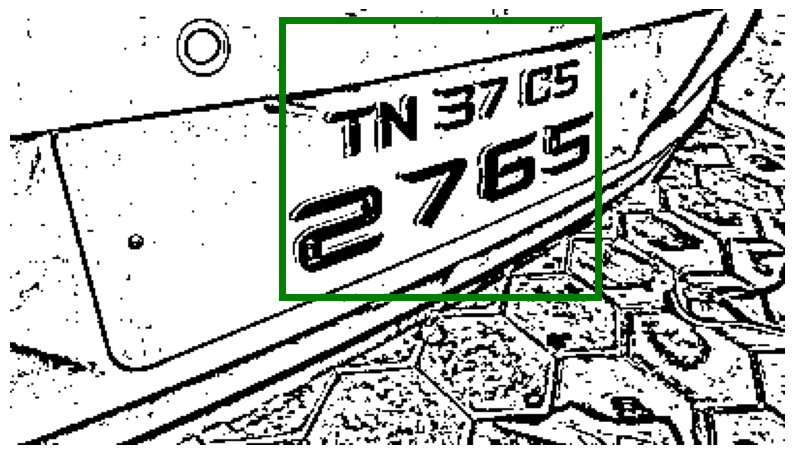

In [ ]:
image_path = f"{n_images_path}/Cars10.png"
img = cv2.imread(image_path)
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
car = df[df['filename'] == 'Cars10.png']
x_min = car['xmin'].values
y_min = car['ymin'].values
square_w = (car['xmax'] - car['xmin']).values
square_h = (car['ymax'] - car['ymin']).values
print(x_min, y_min, square_w, square_h)

for i in range(len(car)):
    ax.add_patch(patches.Rectangle((x_min[i], y_min[i]), square_w[i], square_h[i], linewidth=5, edgecolor='g', facecolor='none'))
plt.show()


Testing locating license plates for more than 1 license plate

In [ ]:
def find_plates(im_name, source):
  image = f"{source}/{im_name}"
  img = cv2.imread(image)
  fig, ax = plt.subplots(1)
  ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')

  car = df[df['filename'] == im_name]
  x_min = car['xmin'].values
  y_min = car['ymin'].values
  square_w = (car['xmax'] - car['xmin']).values
  square_h = (car['ymax'] - car['ymin']).values

  for i in range(len(car)):
    ax.add_patch(patches.Rectangle((x_min[i], y_min[i]), square_w[i], square_h[i], linewidth=3, edgecolor='g', facecolor='none'))
  plt.show()


In [ ]:
find_plates('Cars358.png', n_images_path)

Testing isolating the license plates with a batch of photos (ex: 5) randomly selected from the dataset

In [ ]:
for i in range(5):
  size = df.shape[0]
  rand_im = np.random.randint(0,size)
  im_name = df['filename'].values[rand_im]
  find_plates(im_name, n_images_path)

# Yolov5 using B&W Data only

Create new local folders to store data for training and testing

In [ ]:
#used to reset the directories
#sh.rmtree("dataset/labels/training")
#sh.rmtree("dataset/labels/validation")
#sh.rmtree("dataset/images/training")
#sh.rmtree("dataset/images/validation")
#sh.rmtree("dataset/images")
#sh.rmtree("dataset/labels")

In [ ]:
try:
  os.makedirs("/content/dataset/labels")
except FileExistsError:
  pass

try:
  os.makedirs("/content/dataset/labels/validation")
except FileExistsError:
  pass

try:
  os.makedirs("/content/dataset/labels/training")
except FileExistsError:
  pass

try:
  os.makedirs("/content/dataset/images")
except FileExistsError:
  pass

try:
  os.makedirs("/content/dataset/images/validation")
except FileExistsError:
  pass

try:
  os.makedirs("/content/dataset/images/training")
except FileExistsError:
  pass



Process image annotations and copy images into training and validation folders

In [ ]:
def save_annotation(index, filename, save_path):
  f = open(f"/content/dataset/labels/{save_path}/{filename[:-4]}.txt", 'w+')
  try:
    for row in index[['category', 'center_x', 'center_y', 'square_w', 'square_h']].astype(float).values:
      #f.write(' '.join(map(str, row))+'\n')
      f.write(f"{int(row[0])} {row[1]:.6f} {row[2]:.6f} {row[3]:.6f} {row[4]:.6f}\n")
  finally:
    f.close()

def copy_image(filename, save_path):
  if not os.path.exists(f"{n_images_path}/{filename}"):
    print(f"Image not found: {n_images_path}/{filename}")

  sh.copy(f"{n_images_path}/{filename}",f"/content/dataset/images/{save_path}/{filename}")

for filename, index in tqdm(df.groupby('filename')):
  print(f"Processing {filename}:")
  print(index)  # Print to verify content
  save_path = 'validation' if filename in validation_imgs else 'training'
  save_annotation(index, filename, save_path)
  copy_image(filename, save_path)



List the first 10 folders in the labels training folder and image training folder to demonstrate

In [ ]:
file_list = os.listdir("dataset/images/training")
for i, file in enumerate(file_list[:10]):
  print(f"{i+1}: {file}")

In [ ]:
img_dir = "/content/dataset/images/training"
label_dir = "/content/dataset/labels/training"

images = {os.path.splitext(f)[0] for f in os.listdir(img_dir)}
labels = {os.path.splitext(f)[0] for f in os.listdir(label_dir)}

missing_labels = images - labels
if missing_labels:
    print("Missing labels for:", missing_labels)
else:
    print("All images have labels.")


In [ ]:
!rm -rf yolov5
!git clone https://github.com/ultralytics/yolov5

!pip install -qr yolov5/requirements.txt

#from ultralytics import YOLO
#import torch

!pip install -q wandb --upgrade
import wandb
wandb.login(anonymous='must')

In [ ]:
config = """
path: /content/dataset
train: images/training
val: images/validation
nc: 1
names:
  - licence
"""
config_path = "/content/dataset/config_file.yaml"

with open(config_path, 'w') as config_file:
    config_file.write(config)

with open(config_path, 'r') as config_file:
    content = config_file.read()
    print(content)



In [ ]:
#os.listdir("/content/dataset/imgs/training.cache")
#!rm -f /content/dataset/images/training.cache
#!rm -f /content/dataset/images/validation.cache

#sh.rmtree("/content/datasets")

In [ ]:

base_path = "/content/dataset"
img_dir_train = os.path.join(base_path, "images/training")
label_dir_train = os.path.join(base_path, "labels/training")
img_dir_val = os.path.join(base_path, "images/validation")
label_dir_val = os.path.join(base_path, "labels/validation")

# Helper function to verify matches
def verify_dataset(img_dir, label_dir):
    images = {os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))}
    labels = {os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith('.txt')}
    missing_labels = images - labels
    missing_images = labels - images
    print(f"Images without labels: {missing_labels} with length {len(missing_labels)}")

    print(f"Labels without images: {missing_images} with length {len(missing_images)}")

# Check training and validation sets
print("Training Set:")
verify_dataset(img_dir_train, label_dir_train)

print("\nValidation Set:")
verify_dataset(img_dir_val, label_dir_val)


In [ ]:

label_dir_train = "/content/dataset/labels/training"
label_dir_val = "/content/dataset/labels/validation"

def check_label_files(label_dir):
    for label_file in os.listdir(label_dir):
        path = os.path.join(label_dir, label_file)
        with open(path, 'r') as f:
            content = f.readlines()
            if not content:
                print(f"Empty label file: {label_file}")
            else:
                for line in content:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        print(f"Invalid format in {label_file}: {line}")

print("Checking Training Labels:")
check_label_files(label_dir_train)

print("\nChecking Validation Labels:")
check_label_files(label_dir_val)


In [ ]:
def get_random_seeds():
  return random.randint(1, 1000000)

command = f"""
python yolov5/train.py \\
--img 640 \\
--batch 18 \\
--epochs 30 \\
--data {config_path} \\
--weights yolov5s.pt \\
--name BWmodel_30epochs \\
--cache disk \\
--exist-ok \\
"""

get_ipython().run_cell_magic('bash', '', command)


In [ ]:
results = plt.imread('yolov5/runs/train/BWmodel_30epochs/labels_correlogram.jpg')
fig, ax = plt.subplots(figsize=(13,10))
ax.axis('off')
ax.imshow(results)

In [ ]:
file_path = 'yolov5/runs/train/BWmodel_30epochs/results.png'

img = cv2.imread(file_path)
if img is not None:
    cv2_imshow(img)  # For Google Colab
else:
    print("Error: Could not load image.")


In [ ]:
file_path = 'yolov5/runs/train/BWmodel_30epochs/confusion_matrix.png'

img = cv2.imread(file_path)
if img is not None:
    cv2_imshow(img)  # For Google Colab
else:
    print("Error: Could not load image.")

file_path = 'yolov5/runs/train/BWmodel_30epochs/R_curve.png'

img = cv2.imread(file_path)
if img is not None:
    cv2_imshow(img)  # For Google Colab
else:
    print("Error: Could not load image.")

file_path = 'yolov5/runs/train/BWmodel_30epochs/P_curve.png'

img = cv2.imread(file_path)
if img is not None:
    cv2_imshow(img)  # For Google Colab
else:
    print("Error: Could not load image.")



In [ ]:

best_path = 'yolov5/runs/train/BWmodel_30epochs/weights/best.pt'
yolov5 = torch.hub.load(repo_or_dir='yolov5',model='custom',path=best_path,source='local')

In [ ]:
image_filename = 'Cars150.png'
image_path = f"{images_path}/{image_filename}"
prediction = yolov5(image_path)
prediction.show()

# YoloV5 using RGB Data only

In [ ]:
try:
  os.makedirs("/content/RGBdataset/labels")
except FileExistsError:
  pass

try:
  os.makedirs("/content/RGBdataset/labels/validation")
except FileExistsError:
  pass

try:
  os.makedirs("/content/RGBdataset/labels/training")
except FileExistsError:
  pass

try:
  os.makedirs("/content/RGBdataset/images")
except FileExistsError:
  pass

try:
  os.makedirs("/content/RGBdataset/images/validation")
except FileExistsError:
  pass

try:
  os.makedirs("/content/RGBdataset/images/training")
except FileExistsError:
  pass



In [ ]:
def save_annotation(index, filename, save_path):
  f = open(f"/content/RGBdataset/labels/{save_path}/{filename[:-4]}.txt", 'w+')
  try:
    for row in index[['category', 'center_x', 'center_y', 'square_w', 'square_h']].astype(float).values:
      #f.write(' '.join(map(str, row))+'\n')
      f.write(f"{int(row[0])} {row[1]:.6f} {row[2]:.6f} {row[3]:.6f} {row[4]:.6f}\n")
  finally:
    f.close()

def copy_image(filename, save_path):
  if not os.path.exists(f"{images_path}/{filename}"):
    print(f"Image not found: {images_path}/{filename}")
  f = open(f"/content/RGBdataset/images/{save_path}/{filename}", 'w+')
  sh.copy(f"{images_path}/{filename}",f"/content/RGBdataset/images/{save_path}/{filename}")


for filename, index in tqdm(df.groupby('filename')):
  print(f"Processing {filename}:")
  print(index)  # Print to verify content
  save_path = 'validation' if filename in validation_imgs else 'training'
  save_annotation(index, filename, save_path)
  copy_image(filename, save_path)



In [ ]:
RGBconfig = """
path: /content/RGBdataset
train: images/training
val: images/validation
nc: 1
names:
  - licence
"""
RGBconfig_path = "/content/RGBdataset/RGBconfig_file.yaml"

with open(RGBconfig_path, 'w') as config_file:
    config_file.write(RGBconfig)

with open(RGBconfig_path, 'r') as config_file:
    content = config_file.read()
    print(content)



In [ ]:
def get_random_seeds():
  return random.randint(1, 1000000)

command = f"""
python yolov5/train.py \\
--img 640 \\
--batch 24 \\
--epochs 30 \\
--data {RGBconfig_path} \\
--weights yolov5s.pt \\
--cache  \\
--name RGBmodel_30epochs \\
"""

get_ipython().run_cell_magic('bash', '', command)


In [ ]:
file_path = 'yolov5/runs/train/RGBmodel_30epochs/confusion_matrix.png'

img = cv2.imread(file_path)
if img is not None:
    cv2_imshow(img)  # For Google Colab
else:
    print("Error: Could not load image.")

file_path = 'yolov5/runs/train/RGBmodel_30epochs/R_curve.png'

img = cv2.imread(file_path)
if img is not None:
    cv2_imshow(img)  # For Google Colab
else:
    print("Error: Could not load image.")

file_path = 'yolov5/runs/train/RGBmodel_30epochs/P_curve.png'

img = cv2.imread(file_path)
if img is not None:
    cv2_imshow(img)  # For Google Colab
else:
    print("Error: Could not load image.")



In [ ]:

best_path = 'yolov5/runs/train/RGBmodel_30epochs/weights/best.pt'
yolov5 = torch.hub.load(repo_or_dir='yolov5',model='custom',path=best_path,source='local')

In [ ]:
image_filename = 'Cars150.png'
image_path = f"{images_path}/{image_filename}"
prediction = yolov5(image_path)
prediction.show()

In [ ]:
import shutil
from google.colab import files

# Path to the folder
folder_path = '/content/yolov5/runs/train/BWmodel_30epochs'
zip_path = '/content/yolov5/runs/train/BWmodel_30epochs.zip'

# Compress the folder into a zip file
shutil.make_archive(base_name=folder_path, format='zip', root_dir=folder_path)

# Download the zip file
files.download(zip_path)


In [ ]:
import shutil
from google.colab import files

# Path to the folder
folder_path = '/content/yolov5/runs/train/RGBmodel_30epochs'
zip_path = '/content/yolov5/runs/train/RGBmodel_30epochs.zip'

# Compress the folder into a zip file
shutil.make_archive(base_name=folder_path, format='zip', root_dir=folder_path)

# Download the zip file
files.download(zip_path)


# YoloV5 (pretrained on RGB) using B&W Data for transfer learning

In [9]:
try:
  os.makedirs("ThreeLayerBW_images/")
except FileExistsError:
  pass

ThreeLayerBW_images_path = "ThreeLayerBW_images/"
#sh.copytree(images_path, ThreeLayerBW_images_path, dirs_exist_ok=True)
for image_name in os.listdir(images_path):
  img = cv2.imread(f"{images_path}/{image_name}")
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  thresh_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
  # Converting grayscale image (H,W) to (H,W,3)
  ThreeLayerBW_img = cv2.cvtColor(thresh_img, cv2.COLOR_GRAY2RGB)  # Now it’s 3-channel

  cv2.imwrite(f"{ThreeLayerBW_images_path}/{image_name}", ThreeLayerBW_img)
  print("Saved " + image_name + " to " + ThreeLayerBW_images_path)

Saved Cars264.png to ThreeLayerBW_images/
Saved Cars136.png to ThreeLayerBW_images/
Saved Cars198.png to ThreeLayerBW_images/
Saved Cars186.png to ThreeLayerBW_images/
Saved Cars66.png to ThreeLayerBW_images/
Saved Cars42.png to ThreeLayerBW_images/
Saved Cars236.png to ThreeLayerBW_images/
Saved Cars327.png to ThreeLayerBW_images/
Saved Cars140.png to ThreeLayerBW_images/
Saved Cars29.png to ThreeLayerBW_images/
Saved Cars33.png to ThreeLayerBW_images/
Saved Cars190.png to ThreeLayerBW_images/
Saved Cars390.png to ThreeLayerBW_images/
Saved Cars55.png to ThreeLayerBW_images/
Saved Cars315.png to ThreeLayerBW_images/
Saved Cars305.png to ThreeLayerBW_images/
Saved Cars68.png to ThreeLayerBW_images/
Saved Cars89.png to ThreeLayerBW_images/
Saved Cars397.png to ThreeLayerBW_images/
Saved Cars278.png to ThreeLayerBW_images/
Saved Cars97.png to ThreeLayerBW_images/
Saved Cars369.png to ThreeLayerBW_images/
Saved Cars107.png to ThreeLayerBW_images/
Saved Cars349.png to ThreeLayerBW_images/


In [10]:
!wandb sync --clean
!rm -rf yolov5
!rm -rf wandb
!git clone https://github.com/ultralytics/yolov5

!pip install -qr yolov5/requirements.txt

#from ultralytics import YOLO
#import torch


#pip install -q --upgrade wandb

wandb: Login to W&B to sync offline runs
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: ERROR API key must be 40 characters long, yours was 13
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
No runs older than 24 hours found
Cloning into 'yolov5'...
remote: Enumerating objects: 17075, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 17075 (delta 29), reused 34 (delta 17), pack-reused 17022 (from 1)
Receiving o

In [11]:
try:
  os.makedirs("/content/Mixed_dataset/labels")
except FileExistsError:
  pass

try:
  os.makedirs("/content/Mixed_dataset/labels/validation")
except FileExistsError:
  pass

try:
  os.makedirs("/content/Mixed_dataset/labels/training")
except FileExistsError:
  pass

try:
  os.makedirs("/content/Mixed_dataset/images")
except FileExistsError:
  pass

try:
  os.makedirs("/content/Mixed_dataset/images/validation")
except FileExistsError:
  pass

try:
  os.makedirs("/content/Mixed_dataset/images/training")
except FileExistsError:
  pass



In [12]:
def save_annotation(index, filename, save_path):
  f = open(f"/content/Mixed_dataset/labels/{save_path}/BW{filename[:-4]}.txt", 'w+')
  try:
    for row in index[['category', 'center_x', 'center_y', 'square_w', 'square_h']].astype(float).values:
      #f.write(' '.join(map(str, row))+'\n')
      f.write(f"{int(row[0])} {row[1]:.6f} {row[2]:.6f} {row[3]:.6f} {row[4]:.6f}\n")
  finally:
    f.close()

def copy_image(filename, save_path):
  if not os.path.exists(f"{ThreeLayerBW_images_path}/{filename}"):
    print(f"Image not found: {ThreeLayerBW_images_path}/{filename}")
  f = open(f"/content/Mixed_dataset/images/{save_path}/BW{filename}", 'w+')
  sh.copy(f"{ThreeLayerBW_images_path}/{filename}",f"/content/Mixed_dataset/images/{save_path}/BW{filename}")


for filename, index in tqdm(df.groupby('filename')):
  print(f"Processing {filename}:")
  print(index)  # Print to verify content
  save_path = 'validation' if filename in validation_imgs else 'training'
  save_annotation(index, filename, save_path)
  copy_image(filename, save_path)



 10%|█         | 45/433 [00:00<00:01, 221.08it/s]

Processing Cars0.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
389  Cars0.png  licence    500     268   226   125   419   173         0   

     center_x  center_y  square_w  square_h  
389     0.645   0.55597     0.386  0.179104  
Processing Cars1.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
219  Cars1.png  licence    400     248   134   128   262   160         0   

     center_x  center_y  square_w  square_h  
219     0.495  0.580645      0.32  0.129032  
Processing Cars10.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
312  Cars10.png  licence    400     225   140     5   303   148         0   

     center_x  center_y  square_w  square_h  
312   0.55375      0.34    0.4075  0.635556  
Processing Cars100.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
279  Cars100.png  licence    400     267   175   114   214   131         0   

     center_x  

 21%|██        | 91/433 [00:00<00:01, 221.40it/s]

Processing Cars14.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
341  Cars14.png  licence    400     225    94   118   274   163         0   

     center_x  center_y  square_w  square_h  
341      0.46  0.624444      0.45       0.2  
Processing Cars140.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
59  Cars140.png  licence    435     290   283   239   424   286         0   

    center_x  center_y  square_w  square_h  
59  0.812644  0.905172  0.324138  0.162069  
Processing Cars141.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
21  Cars141.png  licence    400     267   266   169   307   188         0   

    center_x  center_y  square_w  square_h  
21   0.71625  0.668539    0.1025  0.071161  
Processing Cars142.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
220  Cars142.png  licence    400     198   178   124   273   144         0   

     center

 32%|███▏      | 137/433 [00:00<00:01, 223.03it/s]

Processing Cars181.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
63  Cars181.png  licence    225     400    69   195   128   209         0   

    center_x  center_y  square_w  square_h  
63  0.437778     0.505  0.262222     0.035  
Processing Cars182.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
303  Cars182.png  licence    400     225   168   139   247   159         0   

     center_x  center_y  square_w  square_h  
303   0.51875  0.662222    0.1975  0.088889  
Processing Cars183.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
351  Cars183.png  licence    590     350    97   138   234   170         0   

     center_x  center_y  square_w  square_h  
351  0.280508      0.44  0.232203  0.091429  
Processing Cars184.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
104  Cars184.png  licence    400     225   163   146   212   159         0   

    

 42%|████▏     | 183/433 [00:00<00:01, 222.01it/s]

Processing Cars222.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
345  Cars222.png  licence    400     230   178   158   235   170         0   

     center_x  center_y  square_w  square_h  
345   0.51625  0.713043    0.1425  0.052174  
Processing Cars223.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
419  Cars223.png  licence    600     400   347   231   407   249         0   

     center_x  center_y  square_w  square_h  
419  0.628333       0.6       0.1     0.045  
Processing Cars224.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
223  Cars224.png  licence    480     360   181   250   243   275         0   

     center_x  center_y  square_w  square_h  
223  0.441667  0.729167  0.129167  0.069444  
Processing Cars225.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
283  Cars225.png  licence    600     375   189   161   384   215         0   



 53%|█████▎    | 229/433 [00:01<00:00, 224.59it/s]

Processing Cars264.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
163  Cars264.png  licence    400     400   222   300   295   337         0   

     center_x  center_y  square_w  square_h  
163   0.64625   0.79625    0.1825    0.0925  
Processing Cars265.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
164  Cars265.png  licence    400     218    87   166   216   212         0   

     center_x  center_y  square_w  square_h  
164   0.37875  0.866972    0.3225  0.211009  
Processing Cars266.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
254  Cars266.png  licence    400     225    11    57    88    76         0   
255  Cars266.png  licence    400     225    15    84    84   102         0   
256  Cars266.png  licence    400     225    23   110    75   122         0   
257  Cars266.png  licence    400     225    24   150    74   175         0   
258  Cars266.png  licence    400     225

 64%|██████▎   | 275/433 [00:01<00:00, 221.83it/s]

Processing Cars306.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
439  Cars306.png  licence    400     400   139   282   249   310         0   

     center_x  center_y  square_w  square_h  
439     0.485      0.74     0.275      0.07  
Processing Cars307.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
457  Cars307.png  licence    600     417   172   163   437   220         0   

     center_x  center_y  square_w  square_h  
457    0.5075  0.459233  0.441667  0.136691  
Processing Cars308.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
428  Cars308.png  licence    400     300   159   221   237   241         0   

     center_x  center_y  square_w  square_h  
428     0.495      0.77     0.195  0.066667  
Processing Cars309.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
380  Cars309.png  licence    400     225   152   122   252   207         0   



 74%|███████▍  | 321/433 [00:01<00:00, 223.62it/s]

Processing Cars347.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
177  Cars347.png  licence    400     210   227   124   252   135         0   

     center_x  center_y  square_w  square_h  
177   0.59875  0.616667    0.0625  0.052381  
Processing Cars348.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
25  Cars348.png  licence    400     225   156   121   250   204         0   

    center_x  center_y  square_w  square_h  
25    0.5075  0.722222     0.235  0.368889  
Processing Cars349.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
274  Cars349.png  licence    400     267    38   225   146   249         0   

     center_x  center_y  square_w  square_h  
274      0.23   0.88764      0.27  0.089888  
Processing Cars35.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
74  Cars35.png  licence    400     267    91   186   137   208         0   

    cente

 79%|███████▉  | 344/433 [00:01<00:00, 222.65it/s]

Processing Cars388.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
28  Cars388.png  licence    400     300   149   130   255   158         0   

    center_x  center_y  square_w  square_h  
28     0.505      0.48     0.265  0.093333  
Processing Cars389.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
0  Cars389.png  licence    600     450    77   305   222   370         0   

   center_x  center_y  square_w  square_h  
0  0.249167      0.75  0.241667  0.144444  
Processing Cars39.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
432  Cars39.png  licence    400     300   225   180   328   213         0   

     center_x  center_y  square_w  square_h  
432   0.69125     0.655    0.2575      0.11  
Processing Cars390.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
449  Cars390.png  licence    400     300   360   118   397   136         0   
450  Cars390.png

 90%|█████████ | 390/433 [00:01<00:00, 221.26it/s]

Processing Cars429.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
136  Cars429.png  licence    301     400    86   166   208   195         0   

     center_x  center_y  square_w  square_h  
136  0.488372   0.45125  0.405316    0.0725  
Processing Cars43.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
413  Cars43.png  licence    471     270   142   111   319   161         0   

     center_x  center_y  square_w  square_h  
413  0.489384  0.503704  0.375796  0.185185  
Processing Cars430.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
390  Cars430.png  licence    400     225    38   159   116   197         0   

     center_x  center_y  square_w  square_h  
390    0.1925  0.791111     0.195  0.168889  
Processing Cars431.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
70  Cars431.png  licence    400     192    55    82   343   147         0   

    c

100%|██████████| 433/433 [00:01<00:00, 222.07it/s]

Processing Cars81.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
246  Cars81.png  licence    400     300   297   100   327   125         0   

     center_x  center_y  square_w  square_h  
246      0.78     0.375     0.075  0.083333  
Processing Cars82.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
353  Cars82.png  licence    400     151   190    59   257    77         0   

     center_x  center_y  square_w  square_h  
353   0.55875  0.450331    0.1675  0.119205  
Processing Cars83.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
437  Cars83.png  licence    600     450   251   295   326   341         0   

     center_x  center_y  square_w  square_h  
437  0.480833  0.706667     0.125  0.102222  
Processing Cars84.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
129  Cars84.png  licence    400     300   167   201   238   220         0   

     center_

In [13]:
Mixed_config = """
path: /content/Mixed_dataset
train: images/training
val: images/validation
nc: 1
names:
  - licence
"""

Mixed_config_path = "/content/Mixed_dataset/Mixed_config_file.yaml"

with open(Mixed_config_path, 'w') as config_file:
    config_file.write(Mixed_config)

with open(Mixed_config_path, 'r') as config_file:
    content = config_file.read()
    print(content)




path: /content/Mixed_dataset
train: images/training
val: images/validation
nc: 1
names:
  - licence



In [21]:
def get_random_seeds():
  return random.randint(1, 1000000)

rgb_path = "/content/best_models/bestRGB.pt"

command = f"""python yolov5/train.py \
--img 640 \
--batch 24 \
--epochs 30 \
--data {Mixed_config_path} \
--weights {rgb_path} \
--cache \
--name Mixed_model_30epochs
"""

#get_ipython().run_cell_magic('bash', '', f"""WANDB_ANONYMOUS=must""")
get_ipython().run_cell_magic('bash', '', command)


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-14 06:05:29.660824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-14 06:05:29.681458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-14 06:05:29.687672: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bframoslopez (bframoslopez-uc-davis). Use `wandb login --relog

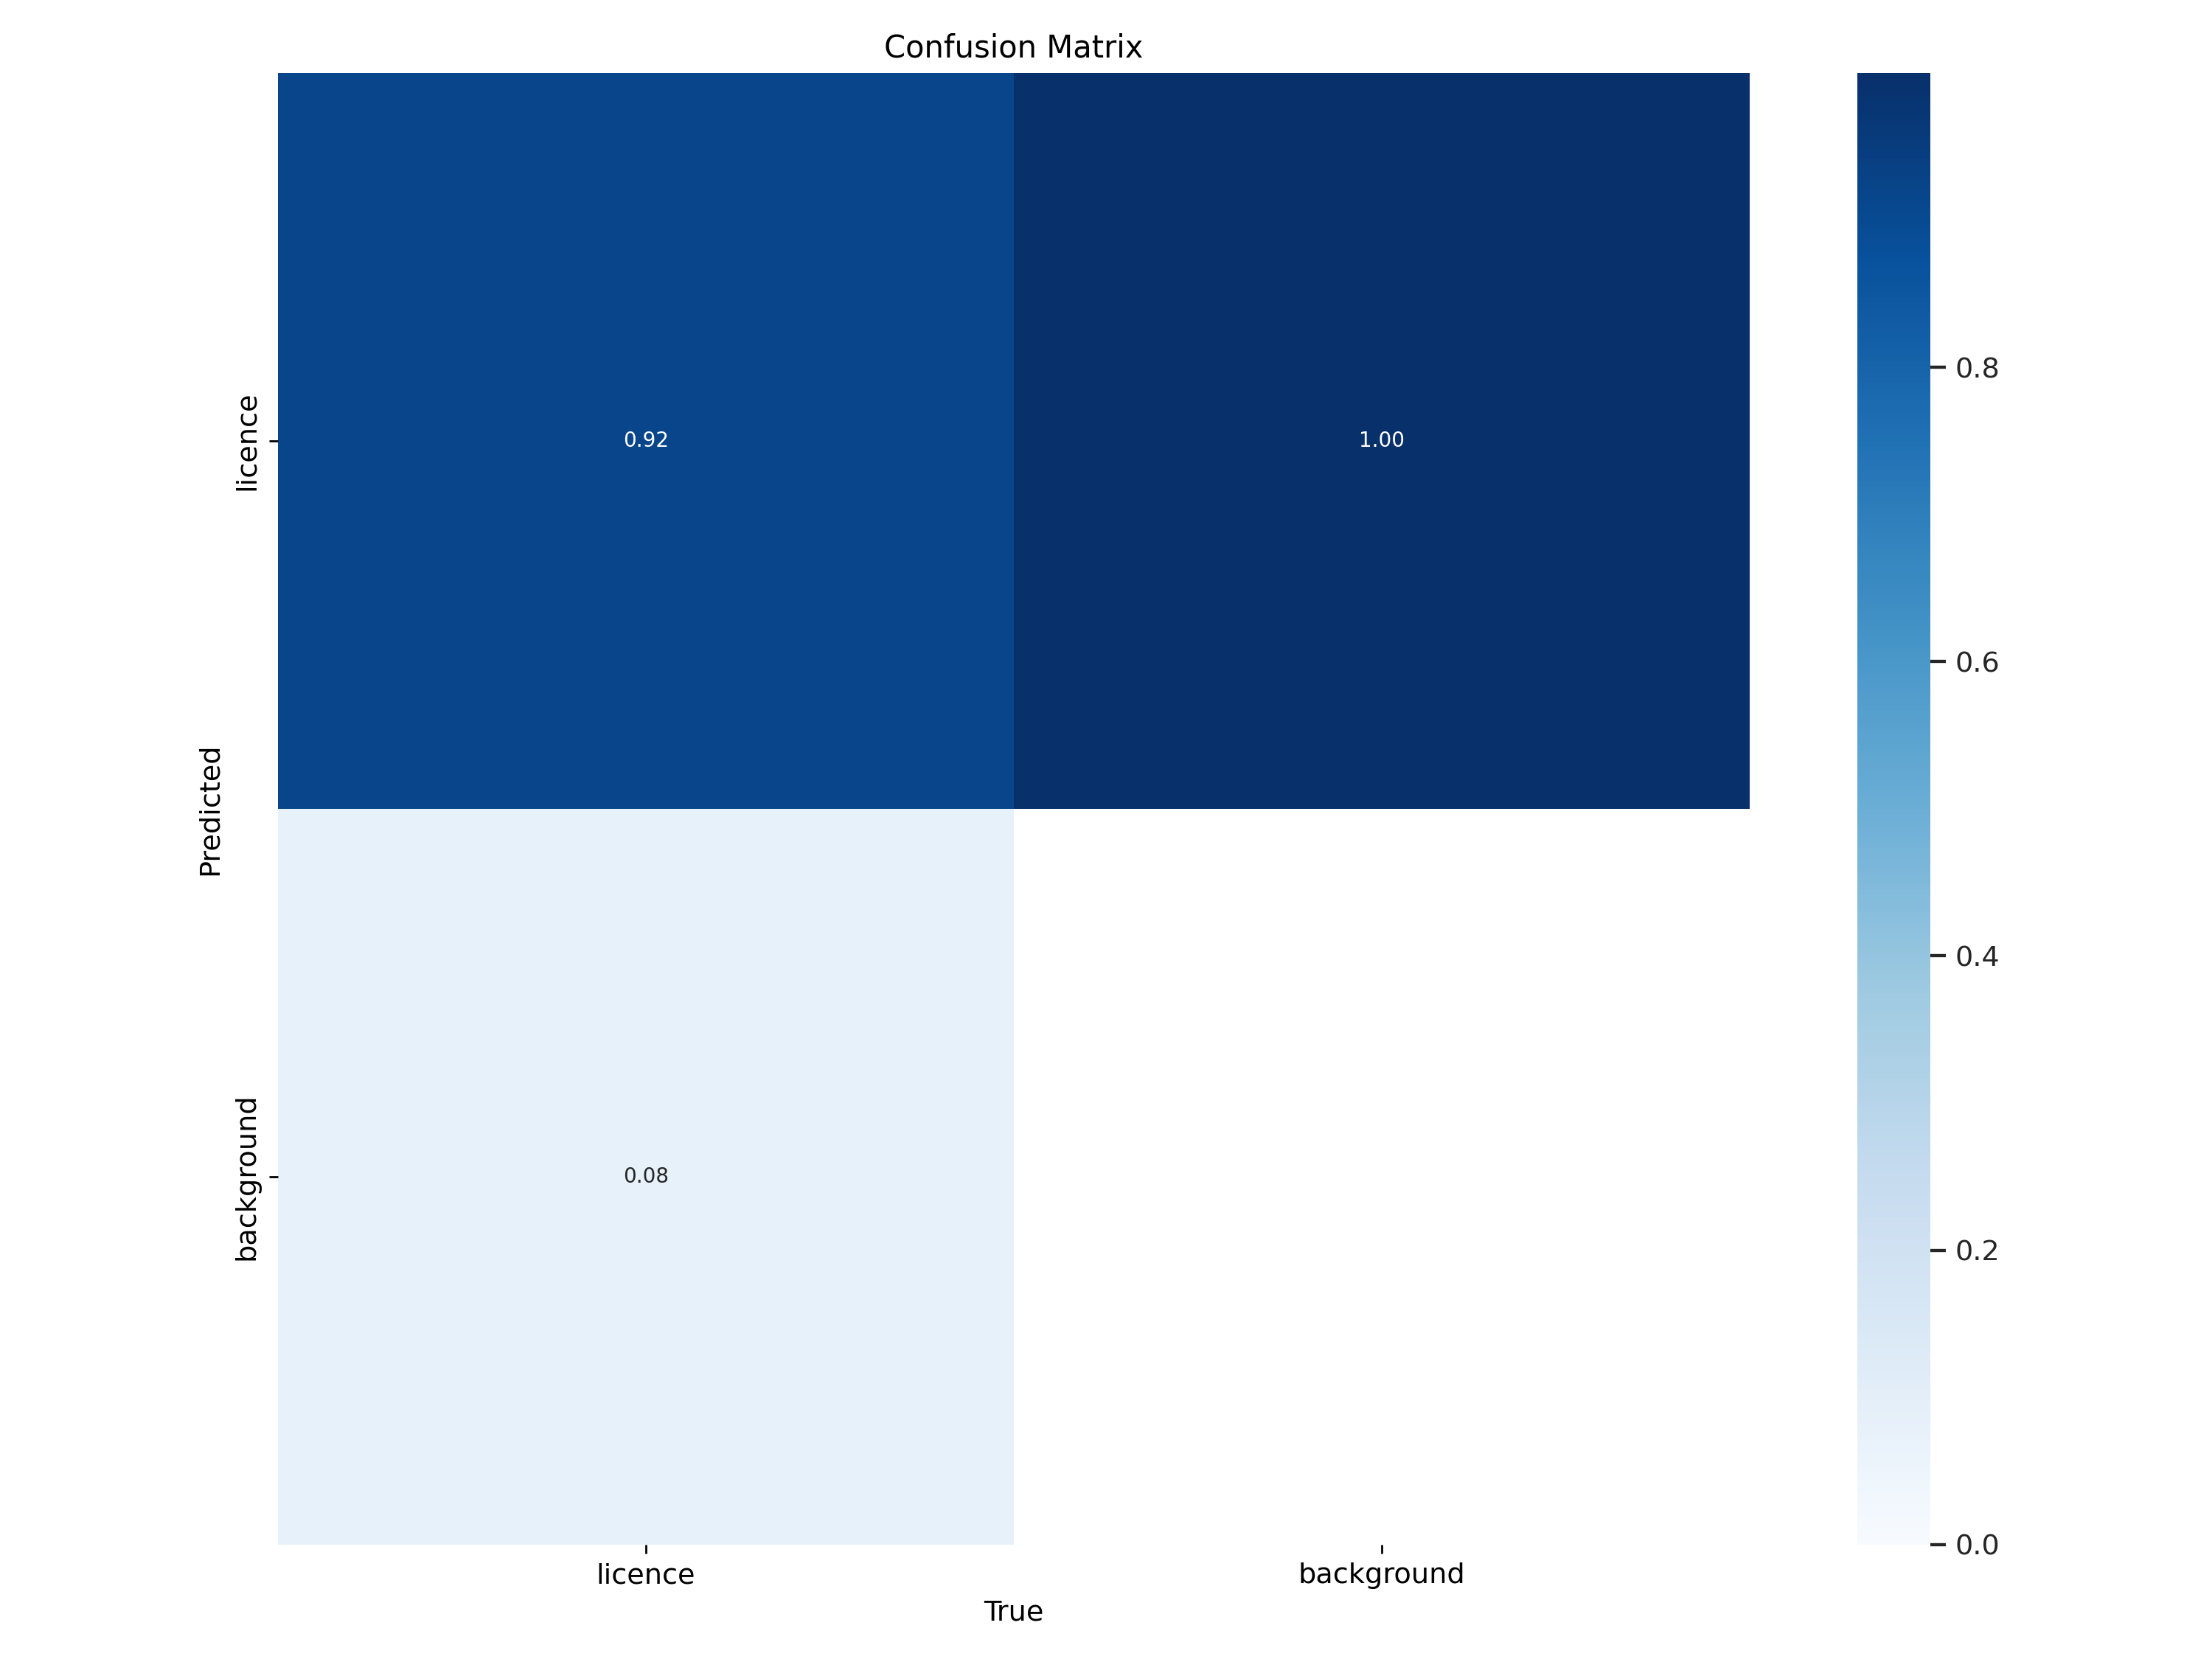

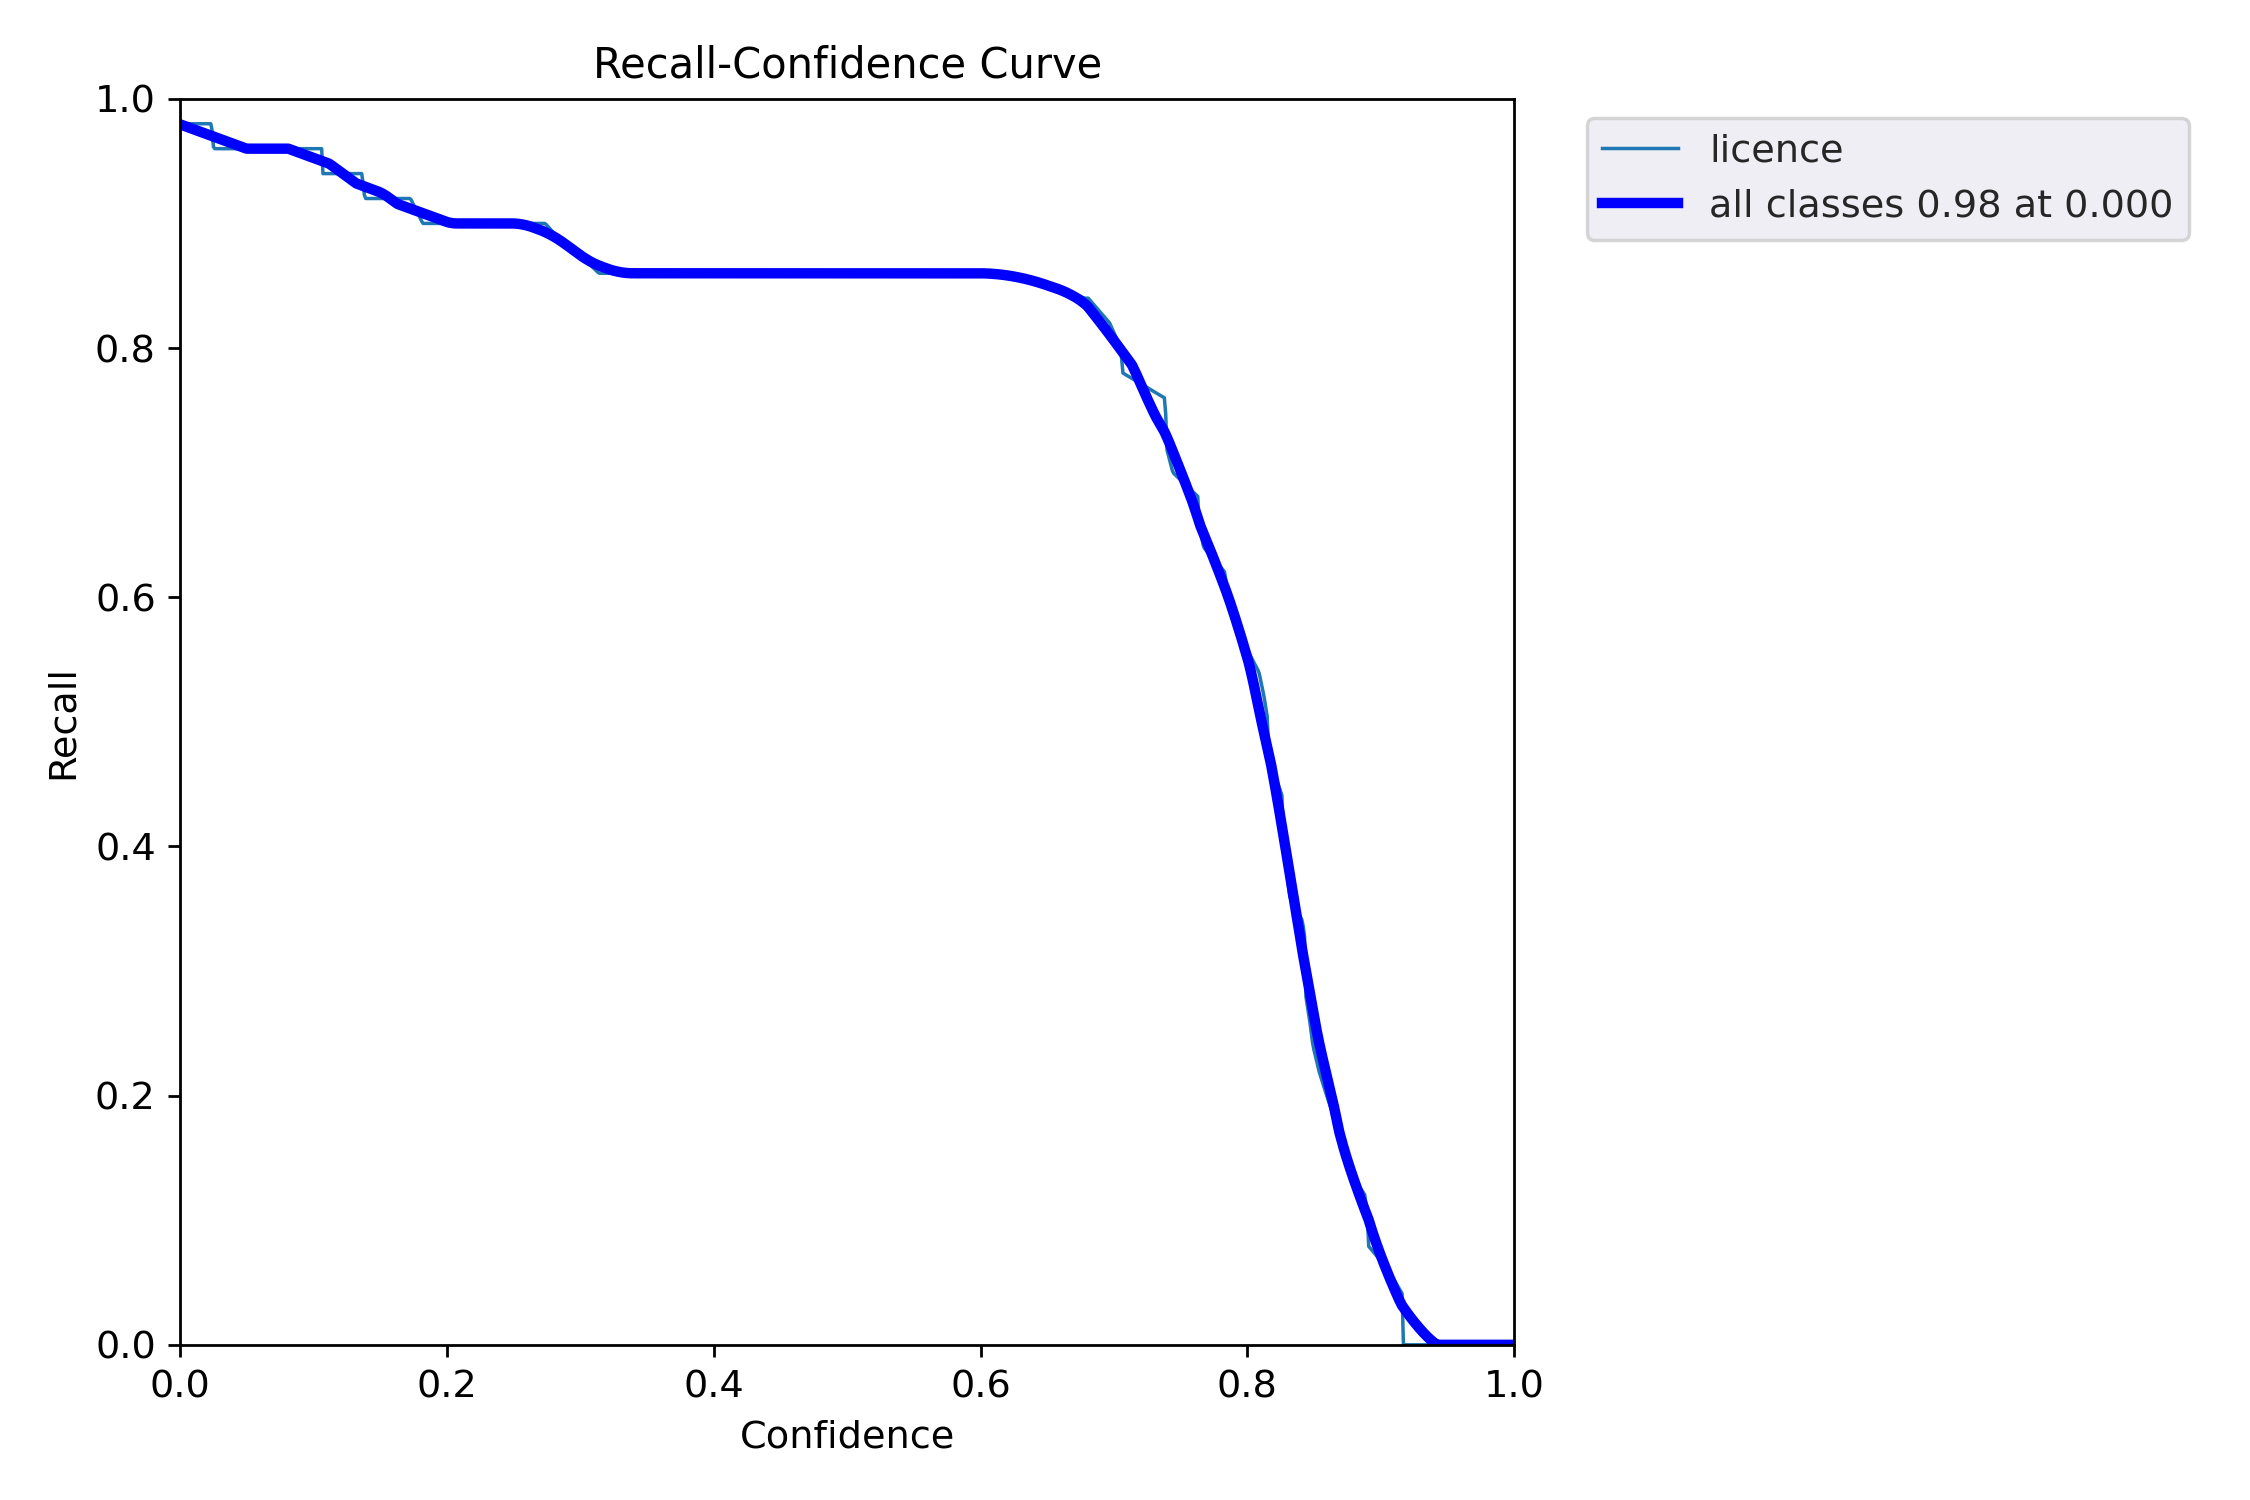

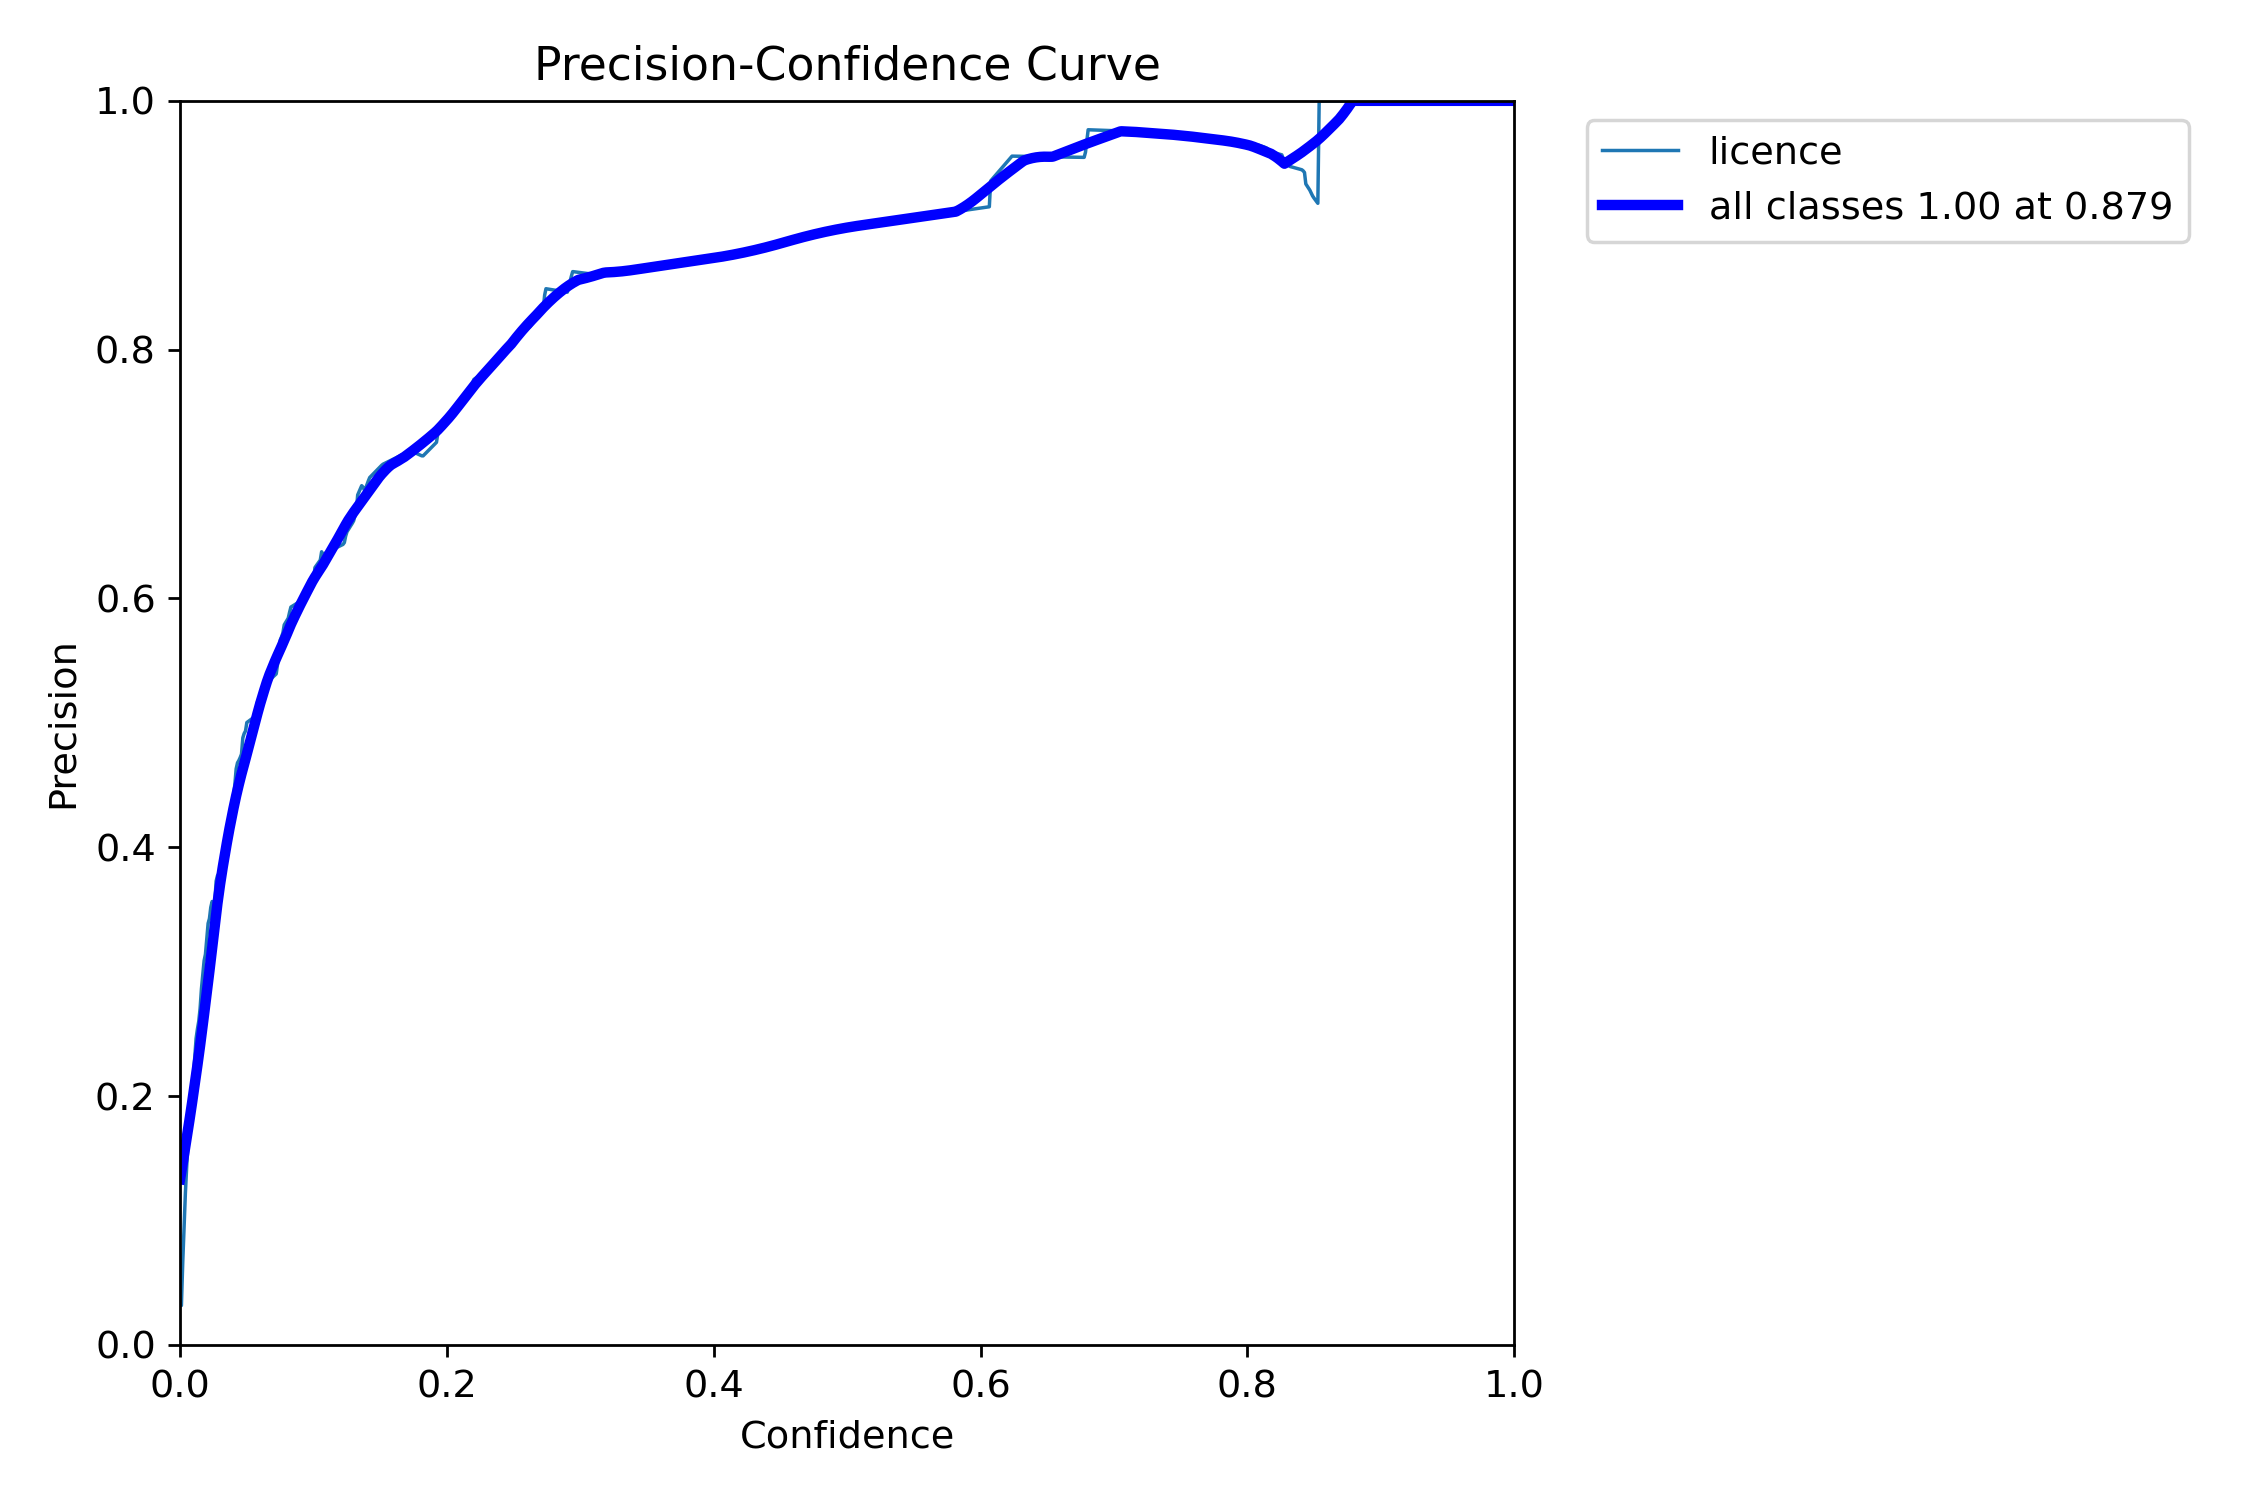

In [22]:
file_path = 'yolov5/runs/train/Mixed_model_30epochs/confusion_matrix.png'

img = cv2.imread(file_path)
if img is not None:
    cv2_imshow(img)
else:
    print("Error: Could not load image.")

file_path = 'yolov5/runs/train/Mixed_model_30epochs/R_curve.png'

img = cv2.imread(file_path)
if img is not None:
    cv2_imshow(img)
else:
    print("Error: Could not load image.")

file_path = 'yolov5/runs/train/Mixed_model_30epochs/P_curve.png'

img = cv2.imread(file_path)
if img is not None:
    cv2_imshow(img)
else:
    print("Error: Could not load image.")



In [23]:
import torch
best_path = 'yolov5/runs/train/Mixed_model_30epochs/weights/best.pt'
yolov5 = torch.hub.load(repo_or_dir='yolov5',model='custom',path=best_path,source='local')

YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


/content/yolov5/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


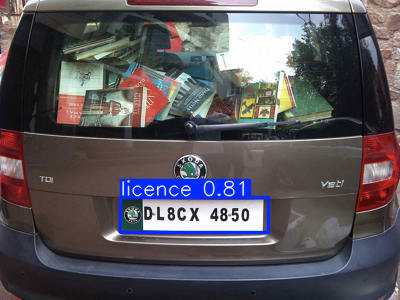

In [24]:
image_filename = 'Cars150.png'
image_path = f"{images_path}/{image_filename}"
prediction = yolov5(image_path)
prediction.show()

In [25]:
import shutil
from google.colab import files

# Path to the folder
folder_path = '/content/yolov5/runs/train/Mixed_model_30epochs'
zip_path = '/content/yolov5/runs/train/Mixed_model_30epochs.zip'

# Compress the folder into a zip file
shutil.make_archive(base_name=folder_path, format='zip', root_dir=folder_path)

# Download the zip file
files.download(zip_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Validation check each model's metrics

In [26]:
try:
  os.makedirs("/content/val_dataset/labels")
except FileExistsError:
  pass

try:
  os.makedirs("/content/val_dataset/labels/validation")
except FileExistsError:
  pass

try:
  os.makedirs("/content/val_dataset/labels/training")
except FileExistsError:
  pass

try:
  os.makedirs("/content/val_dataset/images")
except FileExistsError:
  pass

try:
  os.makedirs("/content/val_dataset/images/validation")
except FileExistsError:
  pass

try:
  os.makedirs("/content/val_dataset/images/training")
except FileExistsError:
  pass



In [27]:
def save_annotation(index, filename, save_path):
  f = open(f"/content/val_dataset/labels/{save_path}/Color{filename[:-4]}.txt", 'w+')
  try:
    for row in index[['category', 'center_x', 'center_y', 'square_w', 'square_h']].astype(float).values:
      #f.write(' '.join(map(str, row))+'\n')
      f.write(f"{int(row[0])} {row[1]:.6f} {row[2]:.6f} {row[3]:.6f} {row[4]:.6f}\n")
  finally:
    f.close()

def copy_image(filename, save_path):
  if not os.path.exists(f"{images_path}/{filename}"):
    print(f"Image not found: {images_path}/{filename}")
  f = open(f"/content/val_dataset/images/{save_path}/Color{filename}", 'w+')
  sh.copy(f"{images_path}/{filename}",f"/content/val_dataset/images/{save_path}/Color{filename}")


for filename, index in tqdm(df.groupby('filename')):
  print(f"Processing {filename}:")
  print(index)  # Print to verify content
  save_path = 'validation' if filename in validation_imgs else 'training'
  save_annotation(index, filename, save_path)
  copy_image(filename, save_path)



  4%|▍         | 17/433 [00:00<00:02, 169.30it/s]

Processing Cars0.png:
      filename     name  width  height  xmin  ...  category  center_x  \
389  Cars0.png  licence    500     268   226  ...         0     0.645   

     center_y  square_w  square_h  
389   0.55597     0.386  0.179104  

[1 rows x 13 columns]
Processing Cars1.png:
      filename     name  width  height  xmin  ...  category  center_x  \
219  Cars1.png  licence    400     248   134  ...         0     0.495   

     center_y  square_w  square_h  
219  0.580645      0.32  0.129032  

[1 rows x 13 columns]
Processing Cars10.png:
       filename     name  width  height  xmin  ...  category  center_x  \
312  Cars10.png  licence    400     225   140  ...         0   0.55375   

     center_y  square_w  square_h  
312      0.34    0.4075  0.635556  

[1 rows x 13 columns]
Processing Cars100.png:
        filename     name  width  height  xmin  ...  category  center_x  \
279  Cars100.png  licence    400     267   175  ...         0   0.48625   

     center_y  square_w  squar

 12%|█▏        | 53/433 [00:00<00:02, 170.16it/s]

Processing Cars13.png:
       filename     name  width  height  xmin  ...  category  center_x  \
324  Cars13.png  licence    400     268   191  ...         0   0.54125   

     center_y  square_w  square_h  
324  0.589552    0.1275   0.08209  

[1 rows x 13 columns]
Processing Cars130.png:
        filename     name  width  height  xmin  ...  category  center_x  \
325  Cars130.png  licence    400     267    91  ...         0   0.32125   

     center_y  square_w  square_h  
325  0.468165    0.1875   0.11236  

[1 rows x 13 columns]
Processing Cars131.png:
        filename     name  width  height  xmin  ...  category  center_x  \
105  Cars131.png  licence    500     300    19  ...         0     0.516   

     center_y  square_w  square_h  
105  0.456667     0.956      0.72  

[1 rows x 13 columns]
Processing Cars132.png:
        filename     name  width  height  xmin  ...  category  center_x  \
153  Cars132.png  licence    400     225    23  ...         0   0.09875   
154  Cars132.png  l

 21%|██        | 89/433 [00:00<00:01, 174.02it/s]

        filename     name  width  height  xmin  ...  category  center_x  \
171  Cars161.png  licence    507     388   312  ...         0  0.708087   

     center_y  square_w  square_h  
171  0.765464  0.185404  0.072165  

[1 rows x 13 columns]
Processing Cars162.png:
        filename     name  width  height  xmin  ...  category  center_x  \
379  Cars162.png  licence    560     315   201  ...         0   0.41875   

     center_y  square_w  square_h  
379  0.604762  0.119643  0.142857  

[1 rows x 13 columns]
Processing Cars163.png:
        filename     name  width  height  xmin  ...  category  center_x  \
262  Cars163.png  licence    590     350   220  ...         0  0.491525   

     center_y  square_w  square_h  
262  0.532857  0.237288  0.077143  

[1 rows x 13 columns]
Processing Cars164.png:
        filename     name  width  height  xmin  ...  category  center_x  \
143  Cars164.png  licence    400     268   160  ...         0   0.49875   

     center_y  square_w  square_h  
143

 29%|██▉       | 125/433 [00:00<00:01, 174.89it/s]

        filename     name  width  height  xmin  ...  category  center_x  \
217  Cars194.png  licence    400     266   267  ...         0   0.72875   

     center_y  square_w  square_h  
217  0.663534    0.1225  0.048872  

[1 rows x 13 columns]
Processing Cars195.png:
        filename     name  width  height  xmin  ...  category  center_x  \
343  Cars195.png  licence    585     331   450  ...         0  0.834188   

     center_y  square_w  square_h  
343  0.705438  0.129915  0.063444  

[1 rows x 13 columns]
Processing Cars196.png:
        filename     name  width  height  xmin  ...  category  center_x  \
192  Cars196.png  licence    400     259   105  ...         0   0.29375   

     center_y  square_w  square_h  
192  0.517375    0.0625  0.046332  

[1 rows x 13 columns]
Processing Cars197.png:
        filename     name  width  height  xmin  ...  category  center_x  \
200  Cars197.png  licence    590     350   222  ...         0  0.492373   

     center_y  square_w  square_h  
200

 37%|███▋      | 161/433 [00:00<00:01, 174.43it/s]

Processing Cars227.png:
        filename     name  width  height  xmin  ...  category  center_x  \
227  Cars227.png  licence    400     267   118  ...         0   0.33875   

     center_y  square_w  square_h  
227   0.76779    0.0875  0.044944  

[1 rows x 13 columns]
Processing Cars228.png:
        filename     name  width  height  xmin  ...  category  center_x  \
352  Cars228.png  licence    400     197    86  ...         0   0.24875   

     center_y  square_w  square_h  
352  0.685279    0.0675  0.081218  

[1 rows x 13 columns]
Processing Cars229.png:
        filename     name  width  height  xmin  ...  category  center_x  \
278  Cars229.png  licence    400     225   253  ...         0   0.67125   

     center_y  square_w  square_h  
278  0.755556    0.0775  0.062222  

[1 rows x 13 columns]
Processing Cars23.png:
       filename     name  width  height  xmin  ...  category  center_x  \
447  Cars23.png  licence    400     299   143  ...         0     0.445   

     center_y  squ

 45%|████▌     | 197/433 [00:01<00:01, 174.28it/s]

Processing Cars259.png:
        filename     name  width  height  xmin  ...  category  center_x  \
211  Cars259.png  licence    600     338   324  ...         0  0.665833   

     center_y  square_w  square_h  
211  0.548817  0.251667  0.115385  

[1 rows x 13 columns]
Processing Cars26.png:
      filename     name  width  height  xmin  ...  category  center_x  \
45  Cars26.png  licence    400     225   258  ...         0   0.72375   

    center_y  square_w  square_h  
45  0.882222    0.1575  0.128889  

[1 rows x 13 columns]
Processing Cars260.png:
        filename     name  width  height  xmin  ...  category  center_x  \
277  Cars260.png  licence    400     240   170  ...         0    0.5025   

     center_y  square_w  square_h  
277  0.502083     0.155  0.070833  

[1 rows x 13 columns]
Processing Cars261.png:
        filename     name  width  height  xmin  ...  category  center_x  \
244  Cars261.png  licence    480     360     1  ...         0  0.484375   

     center_y  square_

 54%|█████▍    | 233/433 [00:01<00:01, 172.83it/s]

Processing Cars290.png:
       filename     name  width  height  xmin  ...  category  center_x  \
86  Cars290.png  licence    400     267   224  ...         0   0.61875   

    center_y  square_w  square_h  
86  0.378277    0.1175  0.127341  

[1 rows x 13 columns]
Processing Cars291.png:
        filename     name  width  height  xmin  ...  category  center_x  \
317  Cars291.png  licence    517     303    71  ...         0  0.276596   

     center_y  square_w  square_h  
317  0.744224   0.27853  0.135314  

[1 rows x 13 columns]
Processing Cars292.png:
        filename     name  width  height  xmin  ...  category  center_x  \
212  Cars292.png  licence    400     267    91  ...         0     0.285   

     center_y  square_w  square_h  
212    0.7397     0.115  0.078652  

[1 rows x 13 columns]
Processing Cars293.png:
      filename     name  width  height  xmin  ...  category  center_x  \
2  Cars293.png  licence    400     267    64  ...         0    0.2425   

   center_y  square_w  

 62%|██████▏   | 269/433 [00:01<00:00, 170.45it/s]

Processing Cars321.png:
        filename     name  width  height  xmin  ...  category  center_x  \
100  Cars321.png  licence    301     400   134  ...         0  0.503322   

     center_y  square_w  square_h  
100   0.60125  0.116279    0.0275  

[1 rows x 13 columns]
Processing Cars322.png:
        filename     name  width  height  xmin  ...  category  center_x  \
305  Cars322.png  licence    400     354   274  ...         0      0.78   

     center_y  square_w  square_h  
305  0.782486      0.19  0.112994  

[1 rows x 13 columns]
Processing Cars323.png:
       filename     name  width  height  xmin  ...  category  center_x  \
48  Cars323.png  licence    400     225   123  ...         0    0.5025   

    center_y  square_w  square_h  
48  0.206667      0.39  0.164444  

[1 rows x 13 columns]
Processing Cars324.png:
        filename     name  width  height  xmin  ...  category  center_x  \
406  Cars324.png  licence    400     225   151  ...         0    0.5075   

     center_y  squa

 70%|███████   | 305/433 [00:01<00:00, 171.72it/s]

Processing Cars352.png:
        filename     name  width  height  xmin  ...  category  center_x  \
367  Cars352.png  licence    300     400   201  ...         0  0.696667   
368  Cars352.png  licence    300     400    77  ...         0  0.285000   

     center_y  square_w  square_h  
367     0.475  0.053333     0.025  
368     0.465  0.056667     0.025  

[2 rows x 13 columns]
Processing Cars353.png:
       filename     name  width  height  xmin  ...  category  center_x  \
19  Cars353.png  licence    400     246    93  ...         0    0.3675   

    center_y  square_w  square_h  
19  0.833333      0.27  0.130081  

[1 rows x 13 columns]
Processing Cars354.png:
       filename     name  width  height  xmin  ...  category  center_x  \
64  Cars354.png  licence    400     267    65  ...         0   0.20875   

    center_y  square_w  square_h  
64  0.794007    0.0925  0.074906  

[1 rows x 13 columns]
Processing Cars355.png:
        filename     name  width  height  xmin  ...  category  

 79%|███████▉  | 341/433 [00:01<00:00, 171.51it/s]

Processing Cars385.png:
        filename     name  width  height  xmin  ...  category  center_x  \
194  Cars385.png  licence    400     250    69  ...         0   0.47375   

     center_y  square_w  square_h  
194     0.532    0.6025     0.464  

[1 rows x 13 columns]
Processing Cars386.png:
       filename     name  width  height  xmin  ...  category  center_x  \
44  Cars386.png  licence    600     450    83  ...         0  0.253333   

    center_y  square_w  square_h  
44      0.75      0.23  0.135556  

[1 rows x 13 columns]
Processing Cars387.png:
        filename     name  width  height  xmin  ...  category  center_x  \
357  Cars387.png  licence    430     286   163  ...         0  0.487209   

     center_y  square_w  square_h  
357   0.72028  0.216279  0.132867  

[1 rows x 13 columns]
Processing Cars388.png:
       filename     name  width  height  xmin  ...  category  center_x  \
28  Cars388.png  licence    400     300   149  ...         0     0.505   

    center_y  square_

 87%|████████▋ | 377/433 [00:02<00:00, 172.88it/s]

Processing Cars417.png:
        filename     name  width  height  xmin  ...  category  center_x  \
178  Cars417.png  licence    400     295    90  ...         0   0.45375   

     center_y  square_w  square_h  
178  0.577966    0.4575  0.172881  

[1 rows x 13 columns]
Processing Cars418.png:
        filename     name  width  height  xmin  ...  category  center_x  \
123  Cars418.png  licence    400     225    99  ...         0    0.5025   

     center_y  square_w  square_h  
123       0.5      0.51  0.377778  

[1 rows x 13 columns]
Processing Cars419.png:
       filename     name  width  height  xmin  ...  category  center_x  \
15  Cars419.png  licence    400     353   195  ...         0      0.68   

    center_y  square_w  square_h  
15  0.620397     0.385  0.130312  

[1 rows x 13 columns]
Processing Cars42.png:
       filename     name  width  height  xmin  ...  category  center_x  \
202  Cars42.png  licence    400     225   177  ...         0    0.4925   

     center_y  square_

 95%|█████████▌| 413/433 [00:02<00:00, 174.80it/s]

Processing Cars60.png:
       filename     name  width  height  xmin  ...  category  center_x  \
289  Cars60.png  licence    400     300    45  ...         0   0.51125   

     center_y  square_w  square_h  
289  0.428333    0.7975  0.203333  

[1 rows x 13 columns]
Processing Cars61.png:
       filename     name  width  height  xmin  ...  category  center_x  \
133  Cars61.png  licence    400     300    71  ...         0   0.33625   

     center_y  square_w  square_h  
133  0.591667    0.3175  0.356667  

[1 rows x 13 columns]
Processing Cars62.png:
       filename     name  width  height  xmin  ...  category  center_x  \
468  Cars62.png  licence    400     300   156  ...         0   0.49875   

     center_y  square_w  square_h  
468  0.448333    0.2175  0.163333  

[1 rows x 13 columns]
Processing Cars63.png:
       filename     name  width  height  xmin  ...  category  center_x  \
106  Cars63.png  licence    400     266    54  ...         0   0.18125   

     center_y  square_w  sq

100%|██████████| 433/433 [00:02<00:00, 172.79it/s]

Processing Cars93.png:
      filename     name  width  height  xmin  ...  category  center_x  \
40  Cars93.png  licence    400     251   347  ...         0    0.8925   

    center_y  square_w  square_h  
40  0.505976      0.05  0.039841  

[1 rows x 13 columns]
Processing Cars94.png:
      filename     name  width  height  xmin  ...  category  center_x  \
52  Cars94.png  licence    400     319   176  ...         0   0.53375   

    center_y  square_w  square_h  
52  0.717868    0.1875  0.119122  

[1 rows x 13 columns]
Processing Cars95.png:
       filename     name  width  height  xmin  ...  category  center_x  \
276  Cars95.png  licence    600     400   278  ...         0  0.570833   

     center_y  square_w  square_h  
276   0.55625     0.215    0.2025  

[1 rows x 13 columns]
Processing Cars96.png:
       filename     name  width  height  xmin  ...  category  center_x  \
378  Cars96.png  licence    400     248   133  ...         0    0.4925   

     center_y  square_w  square_h  

In [28]:
def save_annotation(index, filename, save_path):
  f = open(f"/content/val_dataset/labels/{save_path}/BW{filename[:-4]}.txt", 'w+')
  try:
    for row in index[['category', 'center_x', 'center_y', 'square_w', 'square_h']].astype(float).values:
      #f.write(' '.join(map(str, row))+'\n')
      f.write(f"{int(row[0])} {row[1]:.6f} {row[2]:.6f} {row[3]:.6f} {row[4]:.6f}\n")
  finally:
    f.close()

def copy_image(filename, save_path):
  if not os.path.exists(f"{ThreeLayerBW_images_path}/{filename}"):
    print(f"Image not found: {ThreeLayerBW_images_path}/{filename}")
  f = open(f"/content/val_dataset/images/{save_path}/BW{filename}", 'w+')
  sh.copy(f"{ThreeLayerBW_images_path}/{filename}",f"/content/val_dataset/images/{save_path}/BW{filename}")


for filename, index in tqdm(df.groupby('filename')):
  print(f"Processing {filename}:")
  print(index)  # Print to verify content
  save_path = 'validation' if filename in validation_imgs else 'training'
  save_annotation(index, filename, save_path)
  copy_image(filename, save_path)



  4%|▍         | 19/433 [00:00<00:02, 189.22it/s]

Processing Cars0.png:
      filename     name  width  height  xmin  ...  category  center_x  \
389  Cars0.png  licence    500     268   226  ...         0     0.645   

     center_y  square_w  square_h  
389   0.55597     0.386  0.179104  

[1 rows x 13 columns]
Processing Cars1.png:
      filename     name  width  height  xmin  ...  category  center_x  \
219  Cars1.png  licence    400     248   134  ...         0     0.495   

     center_y  square_w  square_h  
219  0.580645      0.32  0.129032  

[1 rows x 13 columns]
Processing Cars10.png:
       filename     name  width  height  xmin  ...  category  center_x  \
312  Cars10.png  licence    400     225   140  ...         0   0.55375   

     center_y  square_w  square_h  
312      0.34    0.4075  0.635556  

[1 rows x 13 columns]
Processing Cars100.png:
        filename     name  width  height  xmin  ...  category  center_x  \
279  Cars100.png  licence    400     267   175  ...         0   0.48625   

     center_y  square_w  squar

 14%|█▎        | 59/433 [00:00<00:01, 189.35it/s]

Processing Cars133.png:
        filename     name  width  height  xmin  ...  category  center_x  \
364  Cars133.png  licence    600     411   247  ...         0  0.518333   

     center_y  square_w  square_h  
364   0.49635  0.213333  0.092457  

[1 rows x 13 columns]
Processing Cars134.png:
        filename     name  width  height  xmin  ...  category  center_x  \
294  Cars134.png  licence    400     267    76  ...         0   0.26125   

     center_y  square_w  square_h  
294  0.608614    0.1425  0.086142  

[1 rows x 13 columns]
Processing Cars135.png:
        filename     name  width  height  xmin  ...  category  center_x  \
127  Cars135.png  licence    400     225   260  ...         0   0.72375   

     center_y  square_w  square_h  
127  0.877778    0.1475      0.12  

[1 rows x 13 columns]
Processing Cars136.png:
       filename     name  width  height  xmin  ...  category  center_x  \
57  Cars136.png  licence    400     267   164  ...         0   0.51125   

    center_y  squ

 23%|██▎       | 99/433 [00:00<00:01, 191.26it/s]

Processing Cars169.png:
        filename     name  width  height  xmin  ...  category  center_x  \
399  Cars169.png  licence    400     200   114  ...         0   0.42875   

     center_y  square_w  square_h  
399      0.45    0.2875      0.11  

[1 rows x 13 columns]
Processing Cars17.png:
      filename     name  width  height  xmin  ...  category  center_x  \
99  Cars17.png  licence    400     267   306  ...         0   0.82125   

    center_y  square_w  square_h  
99  0.735955    0.1125   0.06367  

[1 rows x 13 columns]
Processing Cars170.png:
        filename     name  width  height  xmin  ...  category  center_x  \
444  Cars170.png  licence    500     365   318  ...         0     0.664   

     center_y  square_w  square_h  
444  0.567123     0.056  0.093151  

[1 rows x 13 columns]
Processing Cars171.png:
        filename     name  width  height  xmin  ...  category  center_x  \
356  Cars171.png  licence    400     268   192  ...         0    0.5425   

     center_y  square_

 32%|███▏      | 139/433 [00:00<00:01, 194.07it/s]

Processing Cars205.png:
        filename     name  width  height  xmin  ...  category  center_x  \
443  Cars205.png  licence    399     400   156  ...         0  0.472431   

     center_y  square_w  square_h  
443   0.45125  0.162907    0.0925  

[1 rows x 13 columns]
Processing Cars206.png:
        filename     name  width  height  xmin  ...  category  center_x  \
124  Cars206.png  licence    400     300    95  ...         0   0.32375   

     center_y  square_w  square_h  
124  0.651667    0.1725      0.07  

[1 rows x 13 columns]
Processing Cars207.png:
       filename     name  width  height  xmin  ...  category  center_x  \
11  Cars207.png  licence    400     478   254  ...         0    0.7825   

    center_y  square_w  square_h  
11   0.51569     0.295  0.073222  

[1 rows x 13 columns]
Processing Cars208.png:
        filename     name  width  height  xmin  ...  category  center_x  \
245  Cars208.png  licence    400     268   142  ...         0    0.4675   

     center_y  squa

 46%|████▌     | 199/433 [00:01<00:01, 194.89it/s]

Processing Cars241.png:
        filename     name  width  height  xmin  ...  category  center_x  \
438  Cars241.png  licence    400     267   126  ...         0   0.45875   

     center_y  square_w  square_h  
438  0.638577    0.2875  0.213483  

[1 rows x 13 columns]
Processing Cars242.png:
       filename     name  width  height  xmin  ...  category  center_x  \
87  Cars242.png  licence    400     400   224  ...         0   0.62625   

    center_y  square_w  square_h  
87   0.46125    0.1325    0.0725  

[1 rows x 13 columns]
Processing Cars243.png:
        filename     name  width  height  xmin  ...  category  center_x  \
209  Cars243.png  licence    600     450   129  ...         0     0.495   

     center_y  square_w  square_h  
209  0.454444      0.56  0.135556  

[1 rows x 13 columns]
Processing Cars244.png:
        filename     name  width  height  xmin  ...  category  center_x  \
242  Cars244.png  licence    400     300    20  ...         0     0.475   

     center_y  squa

 51%|█████     | 219/433 [00:01<00:01, 193.39it/s]

Processing Cars278.png:
       filename     name  width  height  xmin  ...  category  center_x  \
16  Cars278.png  licence    400     201   278  ...         0   0.74125   

    center_y  square_w  square_h  
16  0.748756    0.0925  0.124378  

[1 rows x 13 columns]
Processing Cars279.png:
        filename     name  width  height  xmin  ...  category  center_x  \
182  Cars279.png  licence    400     300    42  ...         0     0.305   

     center_y  square_w  square_h  
182  0.623333       0.4  0.373333  

[1 rows x 13 columns]
Processing Cars28.png:
       filename     name  width  height  xmin  ...  category  center_x  \
400  Cars28.png  licence    600     425   541  ...         0  0.949167   

     center_y  square_w  square_h  
400  0.882353     0.095  0.042353  

[1 rows x 13 columns]
Processing Cars280.png:
       filename     name  width  height  xmin  ...  category  center_x  \
55  Cars280.png  licence    400     267   191  ...         0     0.505   

    center_y  square_w  

 60%|█████▉    | 259/433 [00:01<00:00, 191.16it/s]

Processing Cars312.png:
       filename     name  width  height  xmin  ...  category  center_x  \
29  Cars312.png  licence    590     350   111  ...         0  0.533051   

    center_y  square_w  square_h  
29  0.445714  0.689831  0.514286  

[1 rows x 13 columns]
Processing Cars313.png:
        filename     name  width  height  xmin  ...  category  center_x  \
431  Cars313.png  licence    400     319   176  ...         0     0.535   

     center_y  square_w  square_h  
431  0.716301      0.19  0.109718  

[1 rows x 13 columns]
Processing Cars314.png:
        filename     name  width  height  xmin  ...  category  center_x  \
466  Cars314.png  licence    400     209   195  ...         0   0.58625   

     center_y  square_w  square_h  
466  0.856459    0.1975  0.287081  

[1 rows x 13 columns]
Processing Cars315.png:
        filename     name  width  height  xmin  ...  category  center_x  \
199  Cars315.png  licence    400     300    12  ...         0   0.49625   

     center_y  squa

 69%|██████▉   | 299/433 [00:01<00:00, 191.24it/s]

Processing Cars348.png:
       filename     name  width  height  xmin  ...  category  center_x  \
25  Cars348.png  licence    400     225   156  ...         0    0.5075   

    center_y  square_w  square_h  
25  0.722222     0.235  0.368889  

[1 rows x 13 columns]
Processing Cars349.png:
        filename     name  width  height  xmin  ...  category  center_x  \
274  Cars349.png  licence    400     267    38  ...         0      0.23   

     center_y  square_w  square_h  
274   0.88764      0.27  0.089888  

[1 rows x 13 columns]
Processing Cars35.png:
      filename     name  width  height  xmin  ...  category  center_x  \
74  Cars35.png  licence    400     267    91  ...         0     0.285   

    center_y  square_w  square_h  
74  0.737828     0.115  0.082397  

[1 rows x 13 columns]
Processing Cars350.png:
        filename     name  width  height  xmin  ...  category  center_x  \
179  Cars350.png  licence    400     268   162  ...         0   0.46625   

     center_y  square_w  s

 78%|███████▊  | 339/433 [00:01<00:00, 192.71it/s]

Processing Cars384.png:
       filename     name  width  height  xmin  ...  category  center_x  \
26  Cars384.png  licence    400     300   219  ...         0    0.6125   

    center_y  square_w  square_h  
26  0.706667      0.13      0.12  

[1 rows x 13 columns]
Processing Cars385.png:
        filename     name  width  height  xmin  ...  category  center_x  \
194  Cars385.png  licence    400     250    69  ...         0   0.47375   

     center_y  square_w  square_h  
194     0.532    0.6025     0.464  

[1 rows x 13 columns]
Processing Cars386.png:
       filename     name  width  height  xmin  ...  category  center_x  \
44  Cars386.png  licence    600     450    83  ...         0  0.253333   

    center_y  square_w  square_h  
44      0.75      0.23  0.135556  

[1 rows x 13 columns]
Processing Cars387.png:
        filename     name  width  height  xmin  ...  category  center_x  \
357  Cars387.png  licence    430     286   163  ...         0  0.487209   

     center_y  square_w

 88%|████████▊ | 379/433 [00:01<00:00, 190.09it/s]

Processing Cars419.png:
       filename     name  width  height  xmin  ...  category  center_x  \
15  Cars419.png  licence    400     353   195  ...         0      0.68   

    center_y  square_w  square_h  
15  0.620397     0.385  0.130312  

[1 rows x 13 columns]
Processing Cars42.png:
       filename     name  width  height  xmin  ...  category  center_x  \
202  Cars42.png  licence    400     225   177  ...         0    0.4925   

     center_y  square_w  square_h  
202  0.664444       0.1  0.084444  

[1 rows x 13 columns]
Processing Cars420.png:
       filename     name  width  height  xmin  ...  category  center_x  \
38  Cars420.png  licence    400     300   112  ...         0      0.34   

    center_y  square_w  square_h  
38  0.661667      0.12  0.083333  

[1 rows x 13 columns]
Processing Cars421.png:
        filename     name  width  height  xmin  ...  category  center_x  \
365  Cars421.png  licence    400     299    95  ...         0    0.2775   

     center_y  square_w  s

100%|██████████| 433/433 [00:02<00:00, 191.73it/s]

Processing Cars64.png:
       filename     name  width  height  xmin  ...  category  center_x  \
144  Cars64.png  licence    400     267   120  ...         0   0.55625   

     center_y  square_w  square_h  
144  0.762172    0.5125  0.123596  

[1 rows x 13 columns]
Processing Cars65.png:
       filename     name  width  height  xmin  ...  category  center_x  \
184  Cars65.png  licence    520     424   207  ...         0    0.4875   

     center_y  square_w  square_h  
184  0.542453  0.178846  0.141509  

[1 rows x 13 columns]
Processing Cars66.png:
       filename     name  width  height  xmin  ...  category  center_x  \
196  Cars66.png  licence    400     299   144  ...         0   0.44375   

     center_y  square_w  square_h  
196  0.622074    0.1675  0.107023  

[1 rows x 13 columns]
Processing Cars67.png:
       filename     name  width  height  xmin  ...  category  center_x  \
349  Cars67.png  licence    553     275   189  ...         0   0.46745   

     center_y  square_w  sq

In [34]:
val_config = """
path: /content/val_dataset
train: images/training
val: images/validation
nc: 1
names:
  - licence
"""

val_config_path = "/content/val_dataset/val_config_file.yaml"

with open(val_config_path, 'w') as config_file:
    config_file.write(val_config)

with open(val_config_path, 'r') as config_file:
    content = config_file.read()
    print(content)




path: /content/val_dataset
train: images/training
val: images/validation
nc: 1
names:
  - licence



In [35]:
def get_random_seeds():
  return random.randint(1, 1000000)

rgb_path = "/content/best_models/bestRGB.pt"

command = f"""python yolov5/val.py \
--img 640 \
--data {val_config_path} \
--weights {rgb_path} \
--name RGB_model_30epochs
"""

#get_ipython().run_cell_magic('bash', '', f"""WANDB_ANONYMOUS=must""")
get_ipython().run_cell_magic('bash', '', command)

val: data=/content/val_dataset/val_config_file.yaml, weights=['/content/best_models/bestRGB.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=RGB_model_30epochs, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/val_dataset/labels/validation... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<00:00, 2917.89it/s]
val: New cache created: /content/val_dataset/labels/validation.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]
                   all         88        100      0.94

In [36]:
def get_random_seeds():
  return random.randint(1, 1000000)

bw_path = "/content/best_models/bestBW.pt"

command = f"""python yolov5/val.py \
--img 640 \
--data {val_config_path} \
--weights {bw_path} \
--name BW_model_30epochs
"""

#get_ipython().run_cell_magic('bash', '', f"""WANDB_ANONYMOUS=must""")
get_ipython().run_cell_magic('bash', '', command)

val: data=/content/val_dataset/val_config_file.yaml, weights=['/content/best_models/bestBW.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=BW_model_30epochs, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/val_dataset/labels/validation.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]
                   all         88        100      0.959       0.93      0.973      0.569
Speed: 0.2ms pre-process, 5.6ms inferenc

In [38]:
def get_random_seeds():
  return random.randint(1, 1000000)

mixed_path = "/content/best_models/bestMixed.pt"

command = f"""python yolov5/val.py \
--img 640 \
--data {val_config_path} \
--weights {mixed_path} \
--name Mixed_model_30epochs
"""

#get_ipython().run_cell_magic('bash', '', f"""WANDB_ANONYMOUS=must""")
get_ipython().run_cell_magic('bash', '', command)

val: data=/content/val_dataset/val_config_file.yaml, weights=['/content/best_models/bestMixed.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=Mixed_model_30epochs, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/val_dataset/labels/validation.cache... 88 images, 0 backgrounds, 0 corrupt: 100%|██████████| 88/88 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]
                   all         88        100      0.926      0.876      0.912      0.504
Speed: 0.4ms pre-process, 5.4ms in

In [39]:
import shutil
from google.colab import files

# Path to the folder
folder_path = '/content/yolov5/runs/val'
zip_path = '/content/yolov5/runs/val.zip'

# Compress the folder into a zip file
shutil.make_archive(base_name=folder_path, format='zip', root_dir=folder_path)

# Download the zip file
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Simple CNN Object Detection for Baseline

In [10]:
try:
  os.makedirs("/content/dataset/labels")
except FileExistsError:
  pass

try:
  os.makedirs("/content/dataset/labels/validation")
except FileExistsError:
  pass

try:
  os.makedirs("/content/dataset/labels/training")
except FileExistsError:
  pass

try:
  os.makedirs("/content/dataset/images")
except FileExistsError:
  pass

try:
  os.makedirs("/content/dataset/images/validation")
except FileExistsError:
  pass

try:
  os.makedirs("/content/dataset/images/training")
except FileExistsError:
  pass



In [11]:
def save_annotation(index, filename, save_path):
  f = open(f"/content/dataset/labels/{save_path}/{filename[:-4]}.txt", 'w+')
  try:
    for row in index[['category', 'center_x', 'center_y', 'square_w', 'square_h']].astype(float).values:
      #f.write(' '.join(map(str, row))+'\n')
      f.write(f"{int(row[0])} {row[1]:.6f} {row[2]:.6f} {row[3]:.6f} {row[4]:.6f}\n")
  finally:
    f.close()

def copy_image(filename, save_path):
  if not os.path.exists(f"{images_path}/{filename}"):
    print(f"Image not found: {images_path}/{filename}")

  sh.copy(f"{images_path}/{filename}",f"/content/dataset/images/{save_path}/{filename}")

for filename, index in tqdm(df.groupby('filename')):
  print(f"Processing {filename}:")
  print(index)  # Print to verify content
  save_path = 'validation' if filename in validation_imgs else 'training'
  save_annotation(index, filename, save_path)
  copy_image(filename, save_path)



 10%|▉         | 42/433 [00:00<00:01, 208.40it/s]

Processing Cars0.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
389  Cars0.png  licence    500     268   226   125   419   173         0   

     center_x  center_y  square_w  square_h  
389     0.645   0.55597     0.386  0.179104  
Processing Cars1.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
219  Cars1.png  licence    400     248   134   128   262   160         0   

     center_x  center_y  square_w  square_h  
219     0.495  0.580645      0.32  0.129032  
Processing Cars10.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
312  Cars10.png  licence    400     225   140     5   303   148         0   

     center_x  center_y  square_w  square_h  
312   0.55375      0.34    0.4075  0.635556  
Processing Cars100.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
279  Cars100.png  licence    400     267   175   114   214   131         0   

     center_x  

 19%|█▉        | 84/433 [00:00<00:01, 207.78it/s]

Processing Cars137.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
319  Cars137.png  licence    400     267   178   181   204   191         0   

     center_x  center_y  square_w  square_h  
319    0.4775  0.696629     0.065  0.037453  
Processing Cars138.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
280  Cars138.png  licence    400     301   153   141   254   185         0   

     center_x  center_y  square_w  square_h  
280   0.50875  0.541528    0.2525  0.146179  
Processing Cars139.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
61  Cars139.png  licence    400     300   315   189   337   197         0   
62  Cars139.png  licence    400     300   193   224   231   233         0   

    center_x  center_y  square_w  square_h  
61     0.815  0.643333     0.055  0.026667  
62     0.530  0.761667     0.095  0.030000  
Processing Cars14.png:
       filename     name  width  height 

 29%|██▉       | 126/433 [00:00<00:01, 208.20it/s]

Processing Cars176.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
284  Cars176.png  licence    400     250    72    67   308   185         0   

     center_x  center_y  square_w  square_h  
284     0.475     0.504      0.59     0.472  
Processing Cars177.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
49  Cars177.png  licence    400     238   149   166   272   193         0   

    center_x  center_y  square_w  square_h  
49   0.52625  0.754202    0.3075  0.113445  
Processing Cars178.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
173  Cars178.png  licence    300     223   126   180   173   205         0   

     center_x  center_y  square_w  square_h  
173  0.498333  0.863229  0.156667  0.112108  
Processing Cars179.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
108  Cars179.png  licence    400     267    72   160   132   197         0   

    

 39%|███▉      | 169/433 [00:00<00:01, 209.51it/s]

Processing Cars214.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
424  Cars214.png  licence    400     243   188   121   214   134         0   

     center_x  center_y  square_w  square_h  
424    0.5025  0.524691     0.065  0.053498  
Processing Cars215.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
347  Cars215.png  licence    400     225    92   105   162   123         0   

     center_x  center_y  square_w  square_h  
347    0.3175  0.506667     0.175      0.08  
Processing Cars216.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
8  Cars216.png  licence    530     398   205   214   280   262         0   

   center_x  center_y  square_w  square_h  
8  0.457547   0.59799  0.141509  0.120603  
Processing Cars217.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
210  Cars217.png  licence    400     240   149   196   223   231         0   

     cen

 49%|████▊     | 211/433 [00:01<00:01, 208.94it/s]

        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
134  Cars253.png  licence    400     210    25   124    64   137         0   

     center_x  center_y  square_w  square_h  
134   0.11125  0.621429    0.0975  0.061905  
Processing Cars254.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
1  Cars254.png  licence    400     367   166   175   235   207         0   

   center_x  center_y  square_w  square_h  
1   0.50125  0.520436    0.1725  0.087193  
Processing Cars255.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
308  Cars255.png  licence    400     267   116   156   273   188         0   

     center_x  center_y  square_w  square_h  
308   0.48625  0.644195    0.3925   0.11985  
Processing Cars256.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
103  Cars256.png  licence    400     245   286   175   400   212         0   

     center_x  center_y  square_

 58%|█████▊    | 253/433 [00:01<00:00, 207.88it/s]

Processing Cars292.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
212  Cars292.png  licence    400     267    91   187   137   208         0   

     center_x  center_y  square_w  square_h  
212     0.285    0.7397     0.115  0.078652  
Processing Cars293.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
2  Cars293.png  licence    400     267    64   160   130   181         0   

   center_x  center_y  square_w  square_h  
2    0.2425  0.638577     0.165  0.078652  
Processing Cars294.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
464  Cars294.png  licence    400     267   142   117   218   135         0   

     center_x  center_y  square_w  square_h  
464      0.45   0.47191      0.19  0.067416  
Processing Cars295.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
97  Cars295.png  licence    400     256    52   170    73   182         0   
98  Cars295

 68%|██████▊   | 296/433 [00:01<00:00, 207.83it/s]

Processing Cars330.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
333  Cars330.png  licence    400     300    29   192    57   203         0   
334  Cars330.png  licence    400     300   168   202   198   214         0   
335  Cars330.png  licence    400     300   313   180   333   191         0   
336  Cars330.png  licence    400     300   385   172   399   181         0   

     center_x  center_y  square_w  square_h  
333    0.1075  0.658333     0.070  0.036667  
334    0.4575  0.693333     0.075  0.040000  
335    0.8075  0.618333     0.050  0.036667  
336    0.9800  0.588333     0.035  0.030000  
Processing Cars331.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
332  Cars331.png  licence    560     420   164   220   235   240         0   

     center_x  center_y  square_w  square_h  
332   0.35625  0.547619  0.126786  0.047619  
Processing Cars332.png:
       filename     name  width  height  xmin  ymin  xmax 

 78%|███████▊  | 338/433 [00:01<00:00, 208.60it/s]

Processing Cars37.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
65  Cars37.png  licence    400     268   146   114   246   163         0   

    center_x  center_y  square_w  square_h  
65      0.49  0.516791      0.25  0.182836  
Processing Cars370.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
446  Cars370.png  licence    435     290   285   249   425   276         0   

     center_x  center_y  square_w  square_h  
446  0.816092  0.905172  0.321839  0.093103  
Processing Cars371.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
322  Cars371.png  licence    400     190   313   135   371   150         0   

     center_x  center_y  square_w  square_h  
322     0.855      0.75     0.145  0.078947  
Processing Cars372.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
383  Cars372.png  licence    560     420   221   275   353   309         0   

     ce

 88%|████████▊ | 381/433 [00:01<00:00, 210.75it/s]

Processing Cars408.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
271  Cars408.png  licence    400     267   160   217   187   228         0   

     center_x  center_y  square_w  square_h  
271   0.43375  0.833333    0.0675  0.041199  
Processing Cars409.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
331  Cars409.png  licence    320     276   116   146   203   168         0   

     center_x  center_y  square_w  square_h  
331  0.498437  0.568841  0.271875   0.07971  
Processing Cars41.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
130  Cars41.png  licence    301     400   109   182   159   206         0   

     center_x  center_y  square_w  square_h  
130  0.445183     0.485  0.166113      0.06  
Processing Cars410.png:
        filename     name  width  height  xmin  ymin  xmax  ymax  category  \
459  Cars410.png  licence    301     400    51   150   219   212         0   

   

 98%|█████████▊| 425/433 [00:02<00:00, 210.86it/s]

Processing Cars58.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
440  Cars58.png  licence    400     247   154   166   241   187         0   

     center_x  center_y  square_w  square_h  
440   0.49375  0.714575    0.2175   0.08502  
Processing Cars59.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
397  Cars59.png  licence    400     300   324   162   375   175         0   

     center_x  center_y  square_w  square_h  
397   0.87375  0.561667    0.1275  0.043333  
Processing Cars6.png:
      filename     name  width  height  xmin  ymin  xmax  ymax  category  \
298  Cars6.png  licence    500     375   112   114   373   239         0   

     center_x  center_y  square_w  square_h  
298     0.485  0.470667     0.522  0.333333  
Processing Cars60.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
289  Cars60.png  licence    400     300    45    98   364   159         0   

     center_x  

100%|██████████| 433/433 [00:02<00:00, 208.81it/s]

Processing Cars96.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
378  Cars96.png  licence    400     248   133   126   261   160         0   

     center_x  center_y  square_w  square_h  
378    0.4925  0.576613      0.32  0.137097  
Processing Cars97.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
228  Cars97.png  licence    400     300    98   102   297   191         0   

     center_x  center_y  square_w  square_h  
228   0.49375  0.488333    0.4975  0.296667  
Processing Cars98.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
208  Cars98.png  licence    370     400    85   196   247   259         0   

     center_x  center_y  square_w  square_h  
208  0.448649   0.56875  0.437838    0.1575  
Processing Cars99.png:
       filename     name  width  height  xmin  ymin  xmax  ymax  category  \
372  Cars99.png  licence    375     500    70   198   262   271         0   

     center_

In [12]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

class LicensePlateDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = sorted(os.listdir(self.img_dir))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Corresponding label
        label_path = os.path.join(self.label_dir, img_name.replace('.png', '.txt'))
        with open(label_path, 'r') as f:
            line = f.readline().strip().split()
            # YOLO format: class x_center y_center width height (all normalized)
            class_id, x_center, y_center, width, height = line
            x_center, y_center, width, height = map(float, [x_center, y_center, width, height])

        # Convert to tensor
        if self.transform:
            image = self.transform(image)

        # Targets: We have one bounding box per image + class
        # Let’s store them as a tensor [x_center, y_center, width, height]
        target = torch.tensor([x_center, y_center, width, height], dtype=torch.float)

        return image, target


In [13]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [14]:
from torch.utils.data import DataLoader

train_dataset = LicensePlateDataset(
    img_dir='dataset/images/training',
    label_dir='dataset/labels/training',
    transform=train_transform
)

val_dataset = LicensePlateDataset(
    img_dir='dataset/images/validation',
    label_dir='dataset/labels/validation',
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Two convolutional layers + pooling
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)

        self.fc1 = nn.Linear(32*54*54, 128)
        self.fc2 = nn.Linear(128, 4)  # output: [class, x_center, y_center, width, height]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [16]:
def xywh_to_xyxy(x_center, y_center, w, h, img_width, img_height):
    # Convert normalized coords back to absolute pixel coordinates
    x_min = (x_center - w/2) * img_width
    y_min = (y_center - h/2) * img_height
    x_max = (x_center + w/2) * img_width
    y_max = (y_center + h/2) * img_height
    return x_min, y_min, x_max, y_max

def iou(box1, box2):
    # box format: [x_min, y_min, x_max, y_max]
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    # Compute intersection
    interWidth = max(0, xB - xA)
    interHeight = max(0, yB - yA)
    intersection = interWidth * interHeight

    # Compute area of each box
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    if union == 0:
        return 0.0
    return intersection / union

Epoch [1/30], Loss: 0.9849
Validation Loss: 0.0931
Epoch [2/30], Loss: 0.0855
Validation Loss: 0.0695
Epoch [3/30], Loss: 0.0573
Validation Loss: 0.0438
Epoch [4/30], Loss: 0.0343
Validation Loss: 0.0215
Epoch [5/30], Loss: 0.0192
Validation Loss: 0.0155
Epoch [6/30], Loss: 0.0129
Validation Loss: 0.0107
Epoch [7/30], Loss: 0.0100
Validation Loss: 0.0099
Epoch [8/30], Loss: 0.0085
Validation Loss: 0.0092
Epoch [9/30], Loss: 0.0071
Validation Loss: 0.0086
Epoch [10/30], Loss: 0.0062
Validation Loss: 0.0080
Epoch [11/30], Loss: 0.0049
Validation Loss: 0.0078
Epoch [12/30], Loss: 0.0040
Validation Loss: 0.0074
Epoch [13/30], Loss: 0.0036
Validation Loss: 0.0076
Epoch [14/30], Loss: 0.0032
Validation Loss: 0.0072
Epoch [15/30], Loss: 0.0028
Validation Loss: 0.0073
Epoch [16/30], Loss: 0.0026
Validation Loss: 0.0066
Epoch [17/30], Loss: 0.0025
Validation Loss: 0.0069
Epoch [18/30], Loss: 0.0020
Validation Loss: 0.0066
Epoch [19/30], Loss: 0.0019
Validation Loss: 0.0067
Epoch [20/30], Loss: 

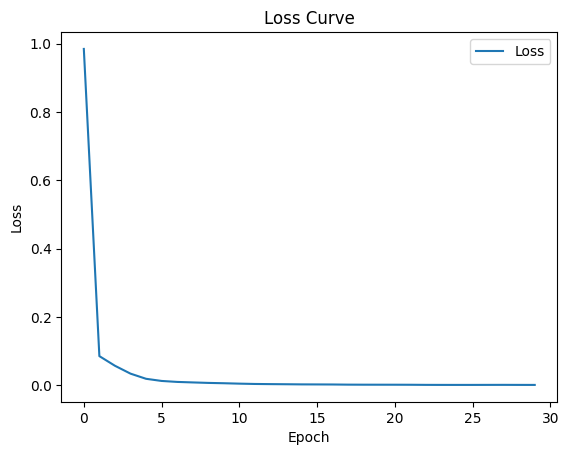

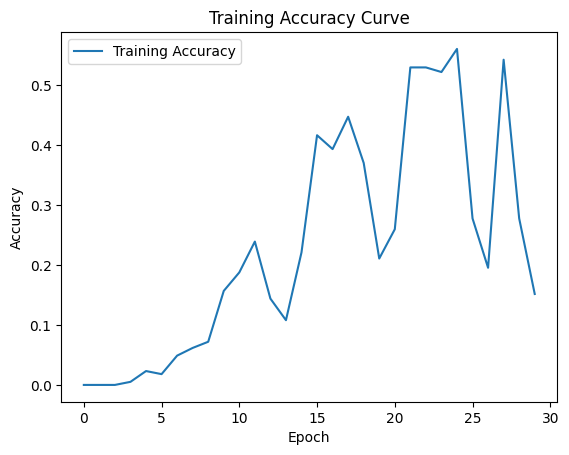

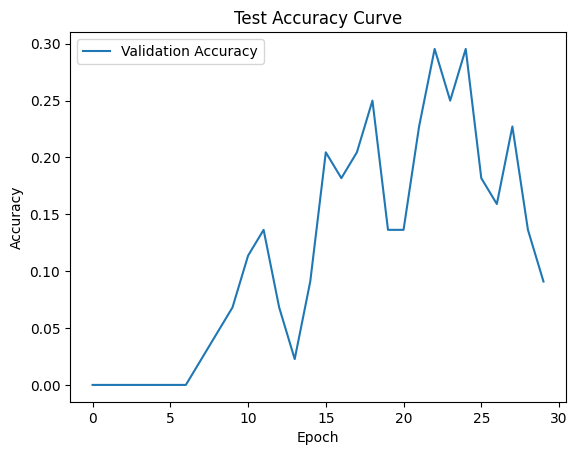

In [17]:
model = SimpleCNN().cuda()

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
losses = []
training_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = images.cuda()
        targets = targets.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.cuda(), targets.cuda()
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")


    # test accuracy
    total_boxes = 0
    correct_boxes = 0
    iou_threshold = 0.5
    with torch.no_grad():
        for images, targets in val_loader:
          images = images.cuda()
          outputs = model(images)

          img_width, img_height = 224, 224

          for i in range(len(images)):
            pred_xywh = outputs[i].cpu().numpy()
            gt_xywh = targets[i].cpu().numpy()

            # Convert both to xyxy
            pred_xyxy = xywh_to_xyxy(pred_xywh[0], pred_xywh[1], pred_xywh[2], pred_xywh[3], img_width, img_height)
            gt_xyxy = xywh_to_xyxy(gt_xywh[0], gt_xywh[1], gt_xywh[2], gt_xywh[3], img_width, img_height)

            # Compute IoU
            box_iou = iou(pred_xyxy, gt_xyxy)

            # Check if IoU is above threshold
            if box_iou >= iou_threshold:
                correct_boxes += 1
            total_boxes += 1

    test_accuracy = correct_boxes / total_boxes if total_boxes > 0 else 0.0

    # train accuracy
    total_boxes = 0
    correct_boxes = 0
    iou_threshold = 0.5
    with torch.no_grad():
        for images, targets in train_loader:
          images = images.cuda()
          outputs = model(images)

          img_width, img_height = 224, 224

          for i in range(len(images)):
            pred_xywh = outputs[i].cpu().numpy()
            gt_xywh = targets[i].cpu().numpy()

            # Convert both to xyxy
            pred_xyxy = xywh_to_xyxy(pred_xywh[0], pred_xywh[1], pred_xywh[2], pred_xywh[3], img_width, img_height)
            gt_xyxy = xywh_to_xyxy(gt_xywh[0], gt_xywh[1], gt_xywh[2], gt_xywh[3], img_width, img_height)

            # Compute IoU
            box_iou = iou(pred_xyxy, gt_xyxy)

            # Check if IoU is above threshold
            if box_iou >= iou_threshold:
                correct_boxes += 1
            total_boxes += 1

    training_accuracy = correct_boxes / total_boxes if total_boxes > 0 else 0.0

    losses.append(epoch_loss)
    training_accuracies.append(training_accuracy)
    test_accuracies.append(test_accuracy)

print('Finished Training')

# Plotting metrics
import matplotlib.pyplot as plt

# Loss plot
plt.figure()
plt.plot(range(num_epochs), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Training accuracy plot
plt.figure()
plt.plot(range(num_epochs), training_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

# Test accuracy plot
plt.figure()
plt.plot(range(num_epochs), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Curve')
plt.legend()
plt.show()


# Backend Model for reading the license plate using EasyOCR

In [ ]:
!pip install easyocr
!pip install imutils

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import easyocr

image = cv2.imread("new_images/Cars18.png")
if image is None:
    print("Error: Image not found or unable to read image file.")
else:
    cv2_imshow(image)

reader = easyocr.Reader(['en'])

text = reader.readtext(image, detail=0)
for line in text:
    print(line)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import easyocr

img = cv2.imread("new_images/Cars15.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(image)

bfilter = cv2.bilateralFilter(gray, 11, 11, 17)
edged = cv2.Canny(bfilter, 30, 200)
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

location = None
for contour in contours:
  # cv2.approxPolyDP returns a resampled contour, so this will still return a set of (x, y) points
  approx = cv2.approxPolyDP(contour, 10, True)
  if len(approx) == 4:
    location = approx
    break

mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask = mask)
cv2_imshow(new_image)